# Predicting voting decisions based on demographics

 - Michael Yee (46430261)
 - Nicholas Wood (46042210)

## Introduction

In Australia, a federal election is held every 4 years to determine the political party that will lead the federal government for the next 4 years. To achieve this, each Australian state and territory is divided into Commonwealth Electoral Divisions (CEDs) or electorates, and the residents of each CED vote in an election for a Member of Parliament to represent them in the federal House of Representatives. Each Member of Parliament occupies a seat in the House of Representatives, and the party that controls more than 50% of all seats is considered to have won the election, with the party leader becoming the new Prime Minister.

From an electoral strategist's point-of-view, the ability to anticipate where their party has strongest and weakest support among voters would be very helpful for planning where to focus their attention and resources. For example, federal political parties may choose to campaign more heavily in key electorates where their party's support is marginal to increase support there, rather than focus on electorates where they already have a high amount of support or electorates where support is so low that additional campaigning is unlikely to have a tangible impact on the outcome in that electorate.

We hypothesised that the different demographic profiles that are associated with each electorate may be used to predict the outcome of elections held in that electorate. Every 5 years, a national census is undertaken by the Australian Bureau of Statistics (ABS) to measure the demographics that make up Australian society. The census contains a battery of questions that quizzes households on factors such as the number of people within the household, their age, gender, occupation, education level and level of income, among many other factors. This data is collated and used in a variety of contexts, such as to inform public policy and identify trends in how the demographics of Australia change over time. The aggregated census data is also made available to the public, so we could use it to develop a predictive model of voting habits per electorate.

## Project Goals

Our aim was to build a model that could predict the outcomes of a federal election in each CED with a reasonable degree of accuracy and thus predict which party will ultimately win control of government at the federal level. This model would be based on demographics measured in the national census. 

We also aimed to identify the specific demographic factors that correlated most strongly with voting choices towards each of the major political parties as well as for minor parties and independent candidates. Finally, we wanted to develop demographic profiles that are characteristic of a given political party's strength in a particular electorate.

In Australia, while there are two houses of Parliament (House of Representatives and the Senate), a political party must win control of over 50% of all electoral seats in the federal House of Representatives only for them to win control of government. Therefore, we only considered and made predictions for the election outcomes for the federal House of Representatives and not the Senate.

## Data Sources

The census data used in our analysis came from the 2016 Census conducted by the ABS. Instead of providing pre-built datasets, the ABS provides a tool called ['TableBuilder'](https://www.abs.gov.au/websitedbs/D3310114.nsf/Home/2016%20TableBuilder), which allows users to build their own datasets. We extracted the following demographic variables aggregated by CED as well as by Statistical Area 1 (SA1) for data cleaning purposes.

 - Age in Five Year Groups (AGE5P)
 - Level of Highest Educational Attainment (HEAP)
 - Total Personal Income (weekly) (INCP)
 - Industry of Employment (INDP)
 - Labour Force Status and Hours Worked Not Stated (LFHRP)
 - Public/Private Sector (GNGP)
 - Registered Marital Status (MSTP)
 - Relationship in Household (RLHP)
 - Religious Affiliation (RELP)
 - Sex (SEXP)
 - Social Marital Status (MDCP)

Australian federal elections are managed by the Australian Electoral Commission (AEC), who release aggregated election data by electorate after each federal election. For our analysis, we used the [2019 Federal Election](https://www.aec.gov.au/elections/federal_elections/2019/index.htm) data to train and test our models. The elections datasets used were made up of the 'Distribution of Preferences By Division' and the 'Two Party Preferred By Division'. The 'Distribution of Preferences By Division' dataset shows how votes were distributed to each candidate in each round of preferences. The 'Two Party Preferred By Division' dataset shows the split of votes between the two major political parties in Australia, the Liberal/National Coalition and the Australian Labor Party.

## Required Libraries

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

from eli5.sklearn import PermutationImportance

## Data Importing and Cleaning

In [2]:
# Define the relevant data paths
raw_data_path = 'datasets/Raw Datasets/'
raw_election_data_path = raw_data_path + 'Electoral Data/'
raw_census_data_path = raw_data_path + 'Census Data/'
clean_data_path = 'datasets/Clean Datasets/'
clean_election_data_path = clean_data_path + 'Electoral Data/'
clean_census_data_path = clean_data_path + 'Census Data/'
other_data_path = raw_data_path + 'Other Data/'

### Census Data

Periodically, there are changes to the boundaries of CEDs to try and ensure each CED contains an approximately similar number of people. Changes can be triggered due to shifting populations or if the seat allocation for a state or territory is increased or decreased. There were 6 states/territories with redistributions that occurred between the 2016 National census and the 2019 Federal election, affecting 84 electorates in total.

To adjust for these changes, we determined the population counts for each Statistical Area Level 1 (SA1), as these boundaries did not change between 2016 and 2019. We then calculated the movement of SA1s between CEDs based on the 2016 and 2018 SA1 to CED correspondences provided by the ABS (2018 was the last time a redistribution occurred prior to the 2019 Federal election). Finally the SA1 population totals were subtracted from the CED that they previously belonged to and were added to the new CED.

In [3]:
# Read files containing SA1 to CED correspondence
ced_2016 = pd.read_csv(other_data_path + 'CED_2016_AUST.csv')[['SA1_MAINCODE_2016', 'CED_NAME_2016']].set_index('SA1_MAINCODE_2016')
ced_2018 = pd.read_csv(other_data_path + 'CED_2018_AUST.csv')[['SA1_MAINCODE_2016', 'CED_NAME_2018']].set_index('SA1_MAINCODE_2016')

In [4]:
ced_to_from = ced_2016.join(ced_2018)
ced_to_from = ced_to_from[ced_to_from['CED_NAME_2016'] != ced_to_from['CED_NAME_2018']].sort_index()
ced_to_from = ced_to_from.reset_index()
ced_to_from['SA1_CODE'] = ced_to_from['SA1_MAINCODE_2016'].transform(lambda x: str(x)[0] + str(x)[-6:])
ced_to_from = ced_to_from.set_index('SA1_CODE')
ced_to_from.drop('SA1_MAINCODE_2016', axis=1, inplace=True)

In [5]:
removed_electorates = set(ced_2016['CED_NAME_2016']) - set(ced_2018['CED_NAME_2018'])
new_electorates = set(ced_2018['CED_NAME_2018']) - set(ced_2016['CED_NAME_2016'])

print("Removed electorates:")
display(removed_electorates)
print("New electorates:")
display(new_electorates)

Removed electorates:


{'Batman',
 'Denison',
 'McMillan',
 'Melbourne Ports',
 'Murray',
 'Port Adelaide',
 'Wakefield'}

New electorates:


{'Bean',
 'Clark',
 'Cooper',
 'Fraser',
 'Macnamara',
 'Monash',
 'Nicholls',
 'Spence'}

In [6]:
ced_files = []
sa1_files = []

for path in os.scandir(raw_census_data_path):
    if path.is_file():
        if path.name[0:3] == 'CED':
            ced_files.append(path.path)
        elif path.name[0:3] == 'SA1':
            sa1_files.append(path.path)

# The following assertion confirms we have as many CED files as SA1 files
assert(len(ced_files) == len(sa1_files))

In [7]:
cens_names = ['Ages (5 year brackets)', 'Education level', 'Income', 'Job (Industry)', 'Labour Force Status',
              'Public-Private Sector', 'Registered Marital Status', 'Relationships in Households', 'Religion',
              'Sex', 'Social Marital Status']

In [8]:
for name in cens_names:
    # Load the census data at SA1 level
    sa1_data = pd.read_csv(raw_census_data_path + 'SA1 to ' + name + '.csv', engine='python', skiprows=9, skipfooter=9).drop(0)
    sa1_data.set_index(sa1_data.columns[0], inplace=True)
    sa1_data = sa1_data.iloc[:,:list(sa1_data.columns).index('Total')]
    
    # Join SA1 data to ced_to_from to calculate totals that should be moved between CEDs
    ced_to_from_data = ced_to_from.join(sa1_data)
    ced_to_from_group_data = ced_to_from_data.groupby(['CED_NAME_2016', 'CED_NAME_2018']).sum().reset_index()
    
    # Load the census data at CED level
    ced_data = pd.read_csv(raw_census_data_path + 'CED to ' + name + '.csv', engine='python', skiprows=9, skipfooter=9).drop(0)
    ced_data = ced_data.iloc[:,:list(ced_data.columns).index('Total')]
    
    # Totals that need to be subtracted from electorates
    rem = ced_to_from_group_data.drop('CED_NAME_2018', axis=1).groupby('CED_NAME_2016').sum()
    # Totals that need to be added to electorates
    ad = ced_to_from_group_data.drop('CED_NAME_2016', axis=1).groupby('CED_NAME_2018').sum()
    
    # Take the data at CED level and add/subtract amounts where SA1s moved between CEDs
    ced_data_clean = ced_data.set_index(ced_data.columns[0])\
        .sub(rem, fill_value=0)\
        .add(ad, fill_value=0)\
        .drop(removed_electorates)\
        .astype(int)
    ced_data_clean.index.rename(ced_data.columns[0], inplace=True)
    
    # Write clean data file
    ced_data_clean.to_csv(clean_census_data_path + 'CED to ' + name + '.csv')

### Election Data

In [9]:
preferences = pd.read_csv(raw_election_data_path + 'HouseDopByDivisionDownload-24310 (3).csv', engine='python', skiprows=1)
fin1 = preferences.drop(columns=['StateAb', 'DivisionID','CandidateID','Surname', 'GivenNm'])
find_final_counts = fin1[['CountNumber', 'DivisionNm']]

In [10]:
counter = find_final_counts.drop_duplicates()
count_number = counter.groupby(['DivisionNm'])['CountNumber'].count()- 1
Final_Count_Number_DF = pd.DataFrame(count_number)
Loop_Column_DF = Final_Count_Number_DF.reset_index()

final_pref_list = []
for x in Loop_Column_DF['DivisionNm']:
    Electorate = fin1[(fin1.DivisionNm == str(x)) & (fin1.CountNumber == count_number[x])]
    final_pref_list.append(Electorate)

The_final_df = pd.concat(final_pref_list)
The_final_df = The_final_df[The_final_df['CalculationType'] != 'Transfer Count']
The_final_df = The_final_df[The_final_df['CalculationType'] != 'Transfer Percent']
The_final_df

,DivisionNm,CountNumber,BallotPosition,PartyAb,PartyNm,Elected,HistoricElected,CalculationType,CalculationValue
14144,Adelaide,4,1,AUD,Australian Democrats,N,N,Preference Count,0.00
14145,Adelaide,4,1,AUD,Australian Democrats,N,N,Preference Percent,0.00
14148,Adelaide,4,2,GRN,The Greens,N,N,Preference Count,0.00
14149,Adelaide,4,2,GRN,The Greens,N,N,Preference Percent,0.00
14152,Adelaide,4,3,ALP,Australian Labor Party,Y,Y,Preference Count,62362.00
...,...,...,...,...,...,...,...,...,...
14037,Wright,6,6,KAP,Katter's Australian Party (KAP),N,N,Preference Percent,0.00
14040,Wright,6,7,ON,Pauline Hanson's One Nation,N,N,Preference Count,0.00
14041,Wright,6,7,ON,Pauline Hanson's One Nation,N,N,Preference Percent,0.00
14044,Wright,6,8,LNP,Liberal National Party of Queensland,Y,Y,Preference Count,62571.00


In [11]:
final_vote_percent = The_final_df.iloc[1::2]
df_percent = final_vote_percent.rename(columns={"CalculationValue" : "PreferencePercent"})

clean_final_vote_count = The_final_df.iloc[::2]
clean_final_vote_count = clean_final_vote_count.rename(columns={"CalculationValue" : "PreferenceCount"})
clean_final_vote_count = clean_final_vote_count.drop(['CalculationType'], axis=1)

merged_df = clean_final_vote_count.merge(df_percent)
final_merged = merged_df.drop('CalculationType', axis=1)
final_merged_no_zeros = final_merged[final_merged['PreferencePercent'] != 0]
final_merged_no_zeros

,DivisionNm,CountNumber,BallotPosition,PartyAb,PartyNm,Elected,HistoricElected,PreferenceCount,PreferencePercent
2,Adelaide,4,3,ALP,Australian Labor Party,Y,Y,62362.0,58.18
4,Adelaide,4,5,LP,Liberal,N,N,44819.0,41.82
6,Aston,3,1,LP,Liberal,Y,Y,60180.0,60.13
8,Aston,3,3,ALP,Australian Labor Party,N,N,39910.0,39.87
16,Ballarat,5,6,LP,Liberal,N,N,40068.0,39.02
...,...,...,...,...,...,...,...,...,...
1038,Wide Bay,5,4,LNP,Liberal National Party of Queensland,Y,Y,59279.0,63.15
1045,Wills,4,4,GVIC,The Greens (VIC),N,N,40192.0,41.83
1047,Wills,4,6,ALP,Australian Labor Party,Y,Y,55898.0,58.17
1051,Wright,6,4,ALP,Australian Labor Party,N,N,34322.0,35.42


In [12]:
# This line can be uncommented to export to csv for future reference
# final_merged_no_zeros.to_csv('../../datasets/Clean Datasets/Electoral Data/Final_Vote_Count.csv')

### Joining Census data with Election data

In [13]:
census_df = pd.DataFrame() # Contain the raw population counts
census_df_norm = pd.DataFrame() # Contain the proportions across demographic categories

for index, path in enumerate(os.scandir(clean_census_data_path)):
    cens_file = pd.read_csv(path.path, index_col=0)
    cens_code = re.match(r'^[0-9a-zA-z]*?(?= )', cens_file.index.name).group(0)
    cens_file = cens_file.add_prefix(cens_code + ' - ')
    cens_file.index.name = 'LGA'
    census_df = census_df.join(cens_file, how='outer')
    cens_file_norm = cens_file.apply(lambda x: x / x.sum(), axis=1)
    census_df_norm = census_df_norm.join(cens_file_norm, how='outer', rsuffix='.' + str(index))

census_df.head()

,AGE5P - 0-4 years,AGE5P - 5-9 years,AGE5P - 10-14 years,AGE5P - 15-19 years,AGE5P - 20-24 years,AGE5P - 25-29 years,AGE5P - 30-34 years,AGE5P - 35-39 years,AGE5P - 40-44 years,AGE5P - 45-49 years,...,RELP - Other Religions,RELP - Secular Beliefs and Other Spiritual Beliefs and No Religious Affiliation,RELP - Inadequately described,RELP - Not stated,SEXP - Male,SEXP - Female,MDCP - Married in a registered marriage,MDCP - Married in a de facto marriage,MDCP - Not married,MDCP - Not applicable
LGA,,,,,,,,,,,,,,,,,,,,,
Adelaide,9761,9178,8226,10379,17511,16760,15961,12706,11645,11514,...,3085,61453,916,16149,89666,91263,54682,13346,65853,46993
Aston,9027,9072,8995,9907,10213,9927,10403,10283,10459,11026,...,1543,52382,833,10797,75339,78821,60719,9364,47066,36980
Ballarat,9317,9830,9140,9362,9801,8961,8781,8860,9512,9905,...,856,55708,870,13249,71979,76811,48120,12179,44914,43598
Banks,9444,9250,8722,9422,10688,11555,11461,10286,10387,10195,...,900,37707,445,10866,75780,80031,60121,6983,52229,36469
Barker,9219,10472,10390,9891,8304,8534,8978,9037,10178,11550,...,1057,58638,712,15358,83654,81960,59520,12946,45347,47779


In [14]:
vote_file = pd.read_csv(clean_election_data_path + 'Final_Vote_Count.csv')
elected = vote_file[vote_file['Elected'] == 'Y'][['DivisionNm', 'PreferencePercent', 'PartyNm']]
elected.set_index('DivisionNm', inplace=True)
elected.head()

,PreferencePercent,PartyNm
DivisionNm,,
Adelaide,58.18,Australian Labor Party
Aston,60.13,Liberal
Ballarat,60.98,Australian Labor Party
Banks,56.26,Liberal
Barker,68.94,Liberal


In [15]:
all_df = census_df.join(elected)
all_df_norm = census_df_norm.join(elected)

In [16]:
# The following lines can be uncommented to export to csv for future reference
# all_df.to_csv(clean_data_path + 'CED to All Demographics and Results.csv')
# all_df_norm.to_csv(clean_data_path + 'CED to All Demographics and Results Norm.csv')

In [17]:
set(all_df[all_df.isna().any(axis=1)].index)

{'Migratory - Offshore - Shipping (ACT)',
 'Migratory - Offshore - Shipping (NSW)',
 'Migratory - Offshore - Shipping (NT)',
 'Migratory - Offshore - Shipping (OT)',
 'Migratory - Offshore - Shipping (Qld)',
 'Migratory - Offshore - Shipping (SA)',
 'Migratory - Offshore - Shipping (Tas.)',
 'Migratory - Offshore - Shipping (Vic.)',
 'Migratory - Offshore - Shipping (WA)',
 'No usual address (ACT)',
 'No usual address (NSW)',
 'No usual address (NT)',
 'No usual address (OT)',
 'No usual address (Qld)',
 'No usual address (SA)',
 'No usual address (Tas.)',
 'No usual address (Vic.)',
 'No usual address (WA)'}

These electorates were present in the census data but not the electoral data, hence they couldn't be joined together and the winning party name is NA. Based on the electorate names, these don't appear to be real electorates and are placeholders for grouping population totals where a person's residence doesn't technically exist in an electorate. For our analysis, we can drop these records.

In [18]:
# Drop unneeded NA
all_df.dropna(inplace=True)
all_df_norm.dropna(inplace=True)

## Data Exploration

### Census Data

In [19]:
list(all_df.columns)

['AGE5P - 0-4 years',
 'AGE5P - 5-9 years',
 'AGE5P - 10-14 years',
 'AGE5P - 15-19 years',
 'AGE5P - 20-24 years',
 'AGE5P - 25-29 years',
 'AGE5P - 30-34 years',
 'AGE5P - 35-39 years',
 'AGE5P - 40-44 years',
 'AGE5P - 45-49 years',
 'AGE5P - 50-54 years',
 'AGE5P - 55-59 years',
 'AGE5P - 60-64 years',
 'AGE5P - 65-69 years',
 'AGE5P - 70-74 years',
 'AGE5P - 75-79 years',
 'AGE5P - 80-84 years',
 'AGE5P - 85-89 years',
 'AGE5P - 90-94 years',
 'AGE5P - 95-99 years',
 'AGE5P - 100 years and over',
 'HEAP - Postgraduate Degree Level',
 'HEAP - Graduate Diploma and Graduate Certificate Level',
 'HEAP - Bachelor Degree Level',
 'HEAP - Advanced Diploma and Diploma Level',
 'HEAP - Certificate III & IV Level',
 'HEAP - Secondary Education - Years 10 and above',
 'HEAP - Certificate I & II Level',
 'HEAP - Secondary Education - Years 9 and below',
 'HEAP - Supplementary Codes',
 'HEAP - Not stated',
 'HEAP - Not applicable',
 'INCP - $1,000-$1,249 ($52,000-$64,999)',
 'INCP - $1,250-$1,

In [20]:
all_df.shape

(151, 140)

In [21]:
set(all_df['PartyNm'])

{'Australian Labor Party',
 'Australian Labor Party (Northern Territory) Branch',
 'Centre Alliance',
 'Independent',
 "Katter's Australian Party (KAP)",
 'Labor',
 'Liberal',
 'Liberal National Party of Queensland',
 'The Greens (VIC)',
 'The Nationals'}

There are 9 political parties (plus independents) that won seats in the federal House of Representatives in the 2019 election. However, some of these parties are either heavily affiliated with each other (e.g. Liberal and The Nationals) or are another branch of the same political party (e.g. Australian Labor Party (Northern Territory) Branch). These will be grouped later in the analysis.

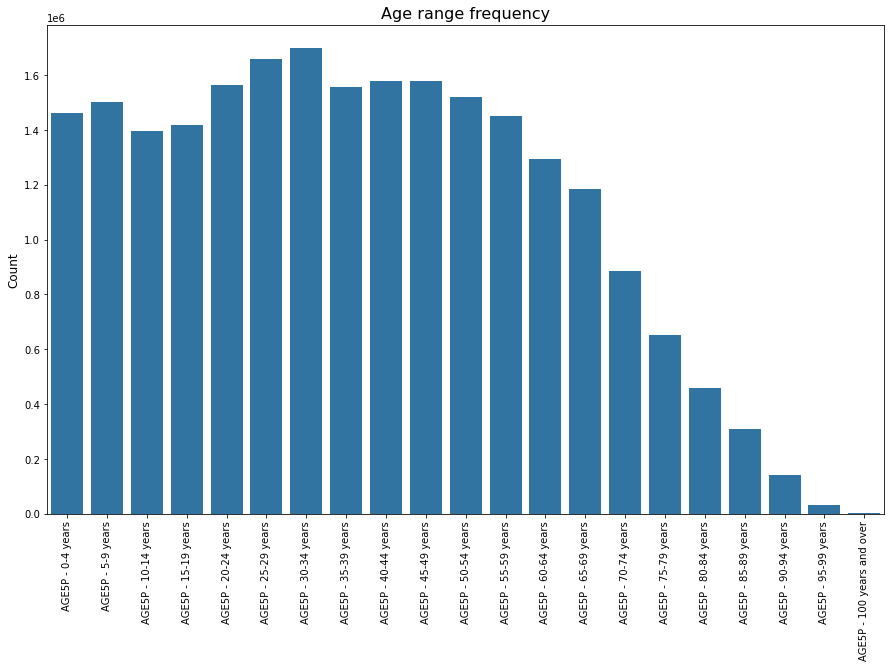

In [22]:
age_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:5] == 'AGE5P')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=age_total, x='x', y='y', color='tab:blue')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count', fontsize=12)
plt.title("Age range frequency", fontsize=16)
plt.show()

The age group with the highest population count is 30-34 years old. After around the age of 50, the population counts decrease gradually in subsequent age groups up to the 100 years and over age group, which accounts for the smallest proportion of the Australian population. 

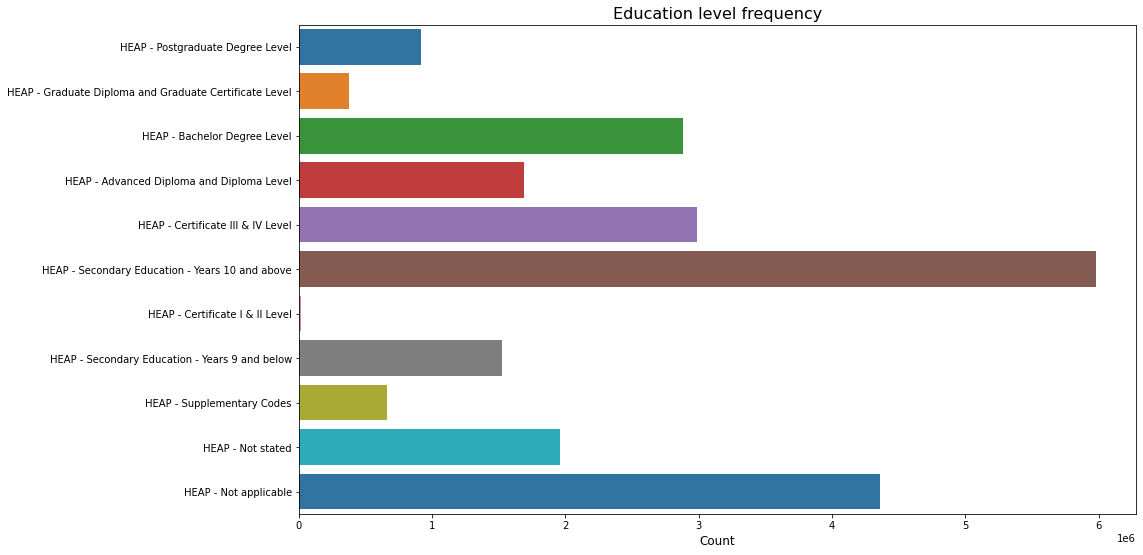

In [23]:
edu_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'HEAP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=edu_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Education level frequency", fontsize=16)
plt.show()

In 2016, the most common education level reached was Secondary Education - Years 10 and above. The number of people who achieved Bachelor degrees and Certificate III & IV was very similar. Notably, the number of people who achieved a higest education level of Certificate I & II was very low, perhaps due to most people opting to study at the Certificate III & IV level instead.

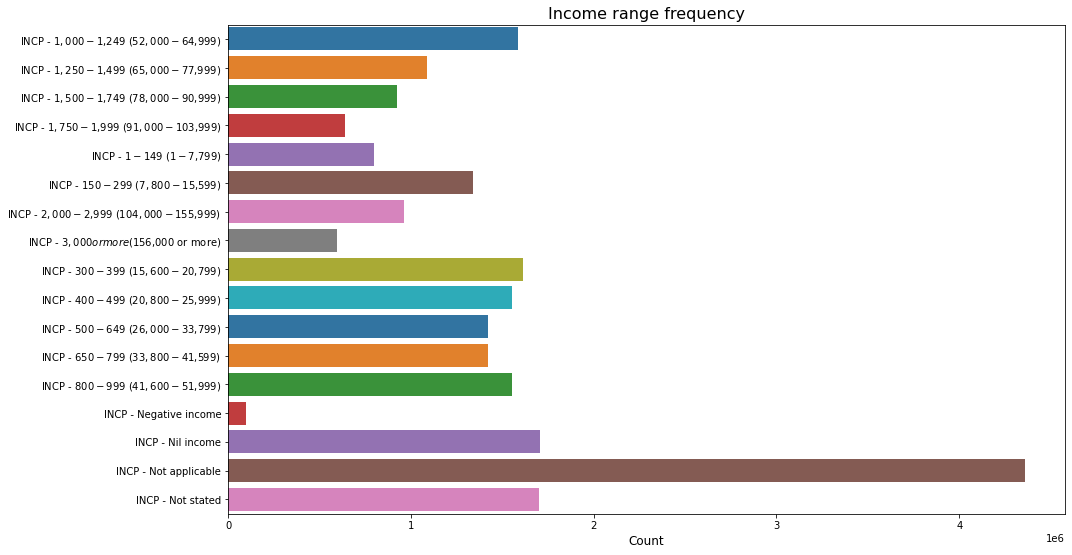

In [24]:
income_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'INCP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=income_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Income range frequency", fontsize=16)
plt.show()

The Not Applicable group had the highest population total of all income groups, possibly due to respondents electing not to answer the question in the census. This may make income level an unreliable feature in the model.

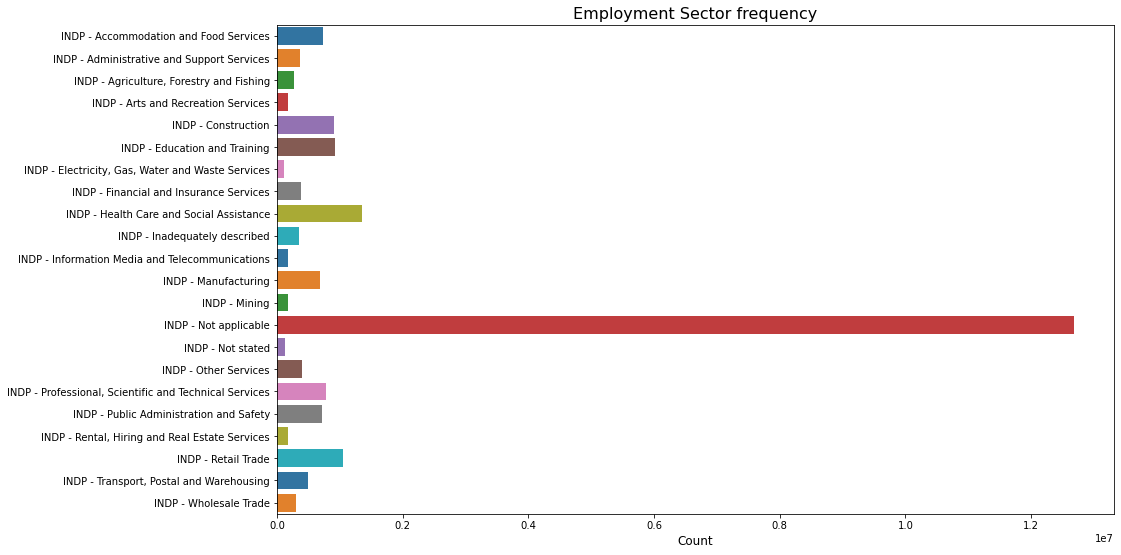

In [25]:
job_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'INDP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=job_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Employment Sector frequency", fontsize=16)
plt.show()

Similarly to income level, the occupation group with the highest population total in the census was Not Applicable. This may be due to respondents being unemployed or not understanding which classification their occupation fell under.

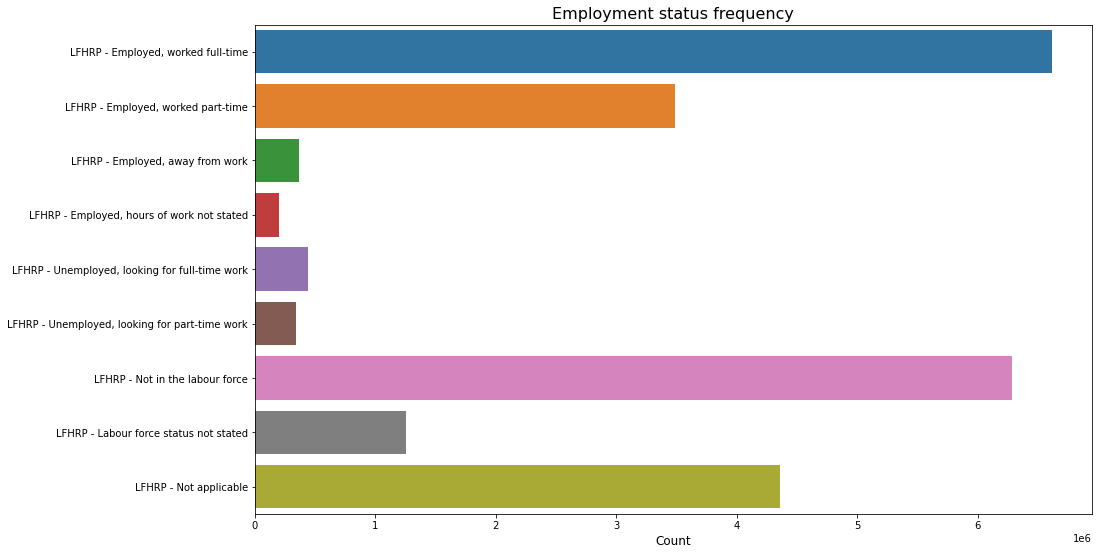

In [26]:
emp_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:5] == 'LFHRP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=emp_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Employment status frequency", fontsize=16)
plt.show()

In 2016 the number of people working full-time hours was slightly higher than the number of people not in the workforce. The population fo part-time workers was approximately half of the number of full-time workers. A significant number of Australians (4.3 million approximately) listed Not Applicable as their employment status. Some of these may be retirees who are past their working age.

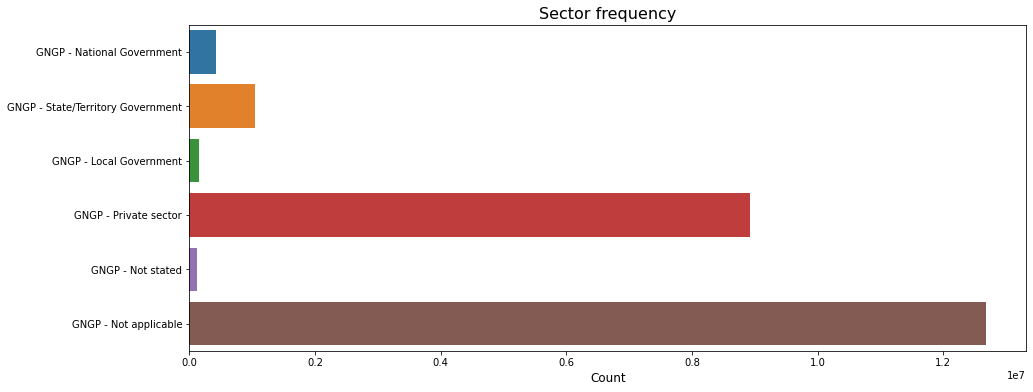

In [27]:
sector_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'GNGP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,6))
sns.barplot(data=sector_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Sector frequency", fontsize=16)
plt.show()

Of the people who stated which sector they worked in, a significant majority reported working in the private sector. However, even more people listed their employment sector as Not Applicable, which may be due to these people being unemployed, retired, or otherwise not in the workforce.

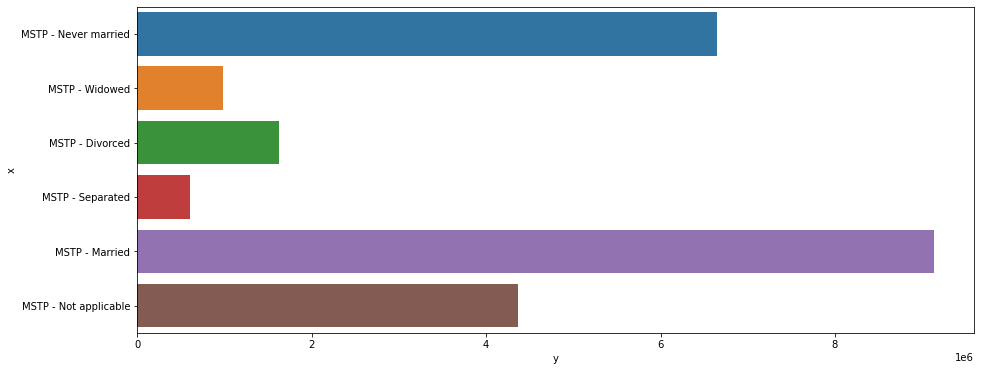

In [28]:
mar_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'MSTP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,6))
sns.barplot(data=mar_total, y='x', x='y', palette='tab10')
plt.show()

Apprximately 9.5 million Australians reported being married in 2016, far more than the number of unmarried people (approximately 6.5 million). Approximately 4.3 million people reported Not Applicable as their marriage status, possibly due to them being ineligible to get married and not reporting their status as Never married.

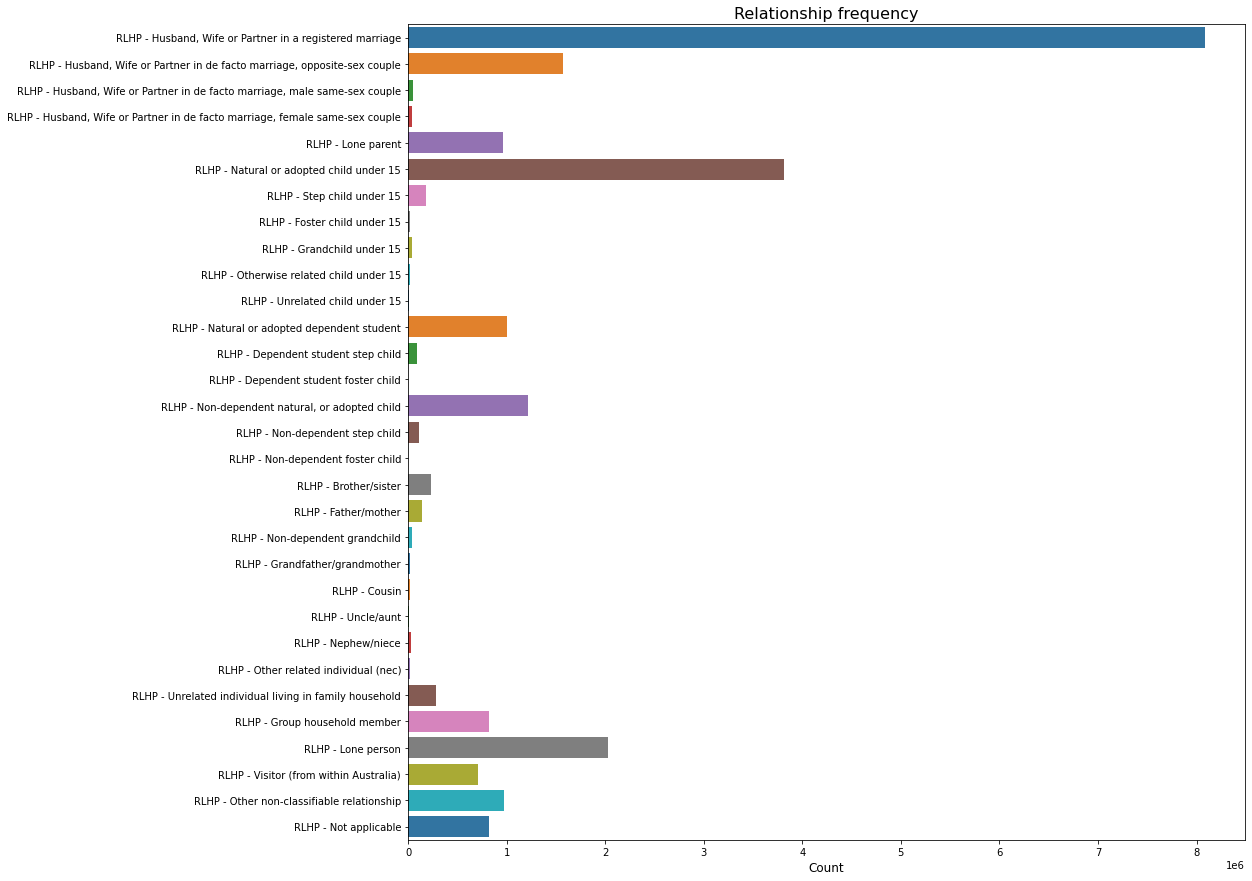

In [29]:
rel_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'RLHP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,15))
sns.barplot(data=rel_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Relationship frequency", fontsize=16)
plt.show()

Over half of all Australians reported either being a husband, wife, or partner in a registered marriage, or being a natural or adopted child under the age of 15.

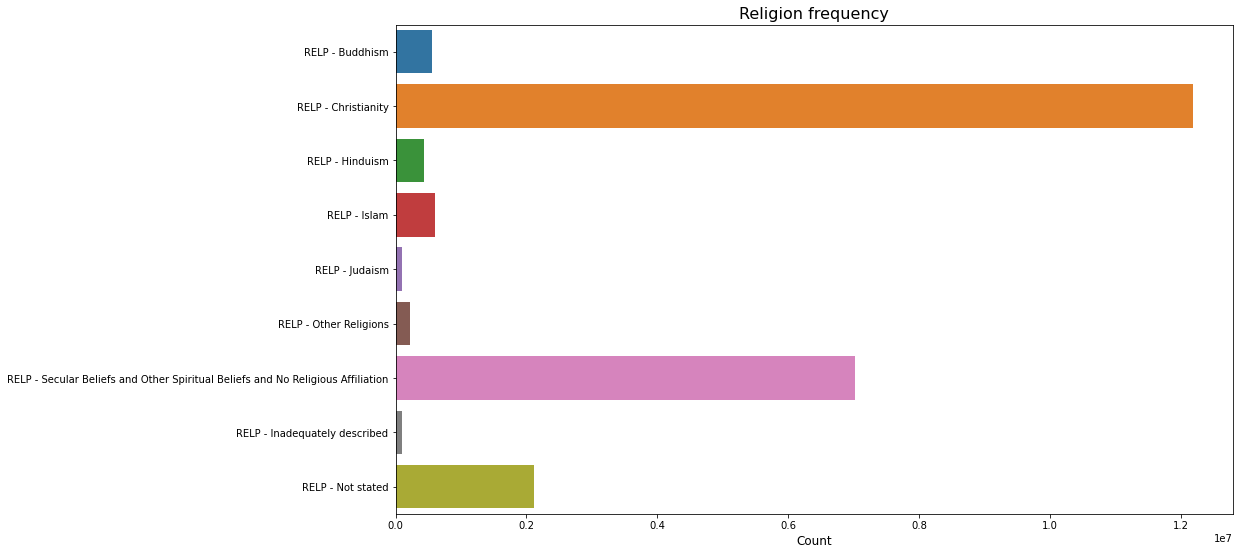

In [30]:
relig_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'RELP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,9))
sns.barplot(data=relig_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Religion frequency", fontsize=16)
plt.show()

In 2016, the most popular religion was Christianity, with approximately half of the Australian population reporting it as their religion. However, a significant proportion of Australians (~7 million) reported having secular beliefs or no religion at all.

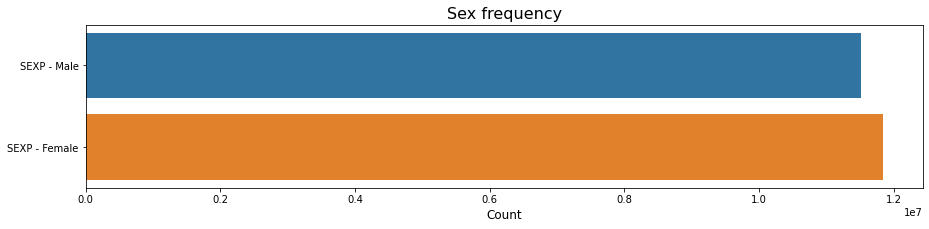

In [31]:
sex_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'SEXP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,3))
sns.barplot(data=sex_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Sex frequency", fontsize=16)
plt.show()

In 2016, there were slightly more women than men reported in the census. Given the relative similarity between these population totals, it is not clear if these features will be useful in our models.

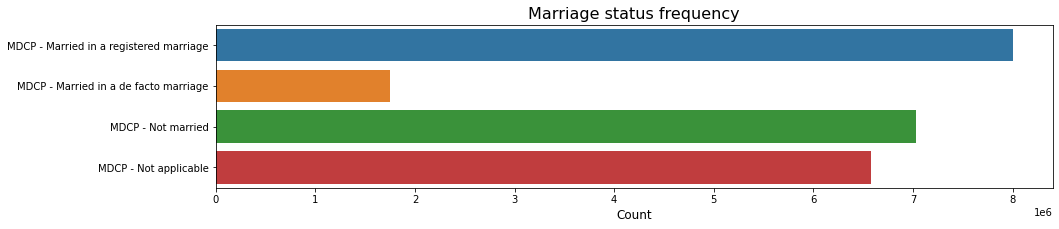

In [32]:
marriage_total = all_df.loc[:,all_df.columns.to_series().apply(lambda x: x[0:4] == 'MDCP')].sum().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,3))
sns.barplot(data=marriage_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Marriage status frequency", fontsize=16)
plt.show()

Of the ~9.5 million Australians who reported being in a marriage in 2016, 8 million were in a registered marriage and ~1.5 million were in a defacto (non-registered) marriage.

### Election Data

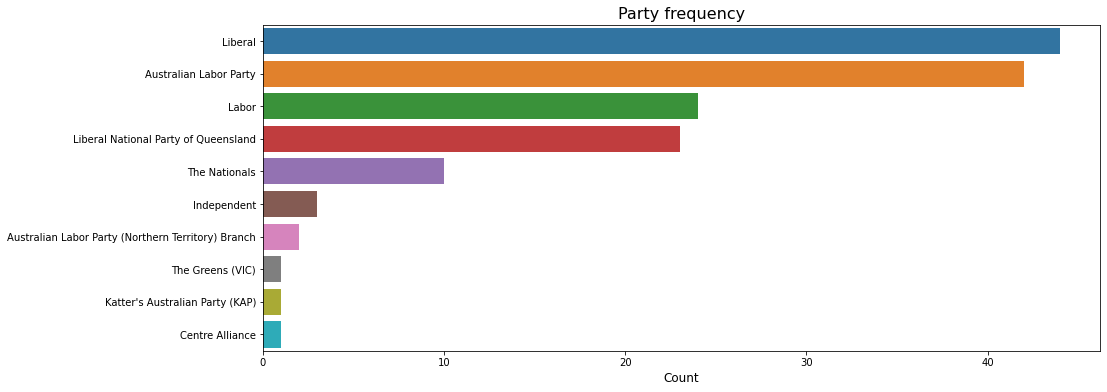

In [33]:
party_total = all_df['PartyNm'].value_counts().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,6))
sns.barplot(data=party_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.title("Party frequency", fontsize=16)
plt.show()

In 2019, the Liberal/National Coalition won the election with 77 seats in total. The Labor party came in second, winning 68 seats in total. There were also 3 minor parties that managed to win one seat each, the Centre Alliance, Katter's Australian Party, and The Greens, as well as 3 independent candidates that were elected to the House of Representatives.

## Model Building

## Logistic Regression

### There are 2 sets of Logistic Regression Models:

1) The Major party predicting models (is_ALP, is_LNP, is_Other), used for determining victory of an election.

2) The Seat Type models (is_Marginal, is_Fairly_Safe_ALP, is_Fairly_Safe_LNP, is_Safe_ALP, is_Safe_LNP, is_Other_Strength), used to derive further interesting characterisitics of electorates. This further divides classifications into type of seat (Marginal, Fairly safe & Safe), as defined in the glossary of terms provided by the __[AEC](https://www.aec.gov.au/footer/glossary.htm#:~:text=Marginal%20seat,per%20cent%20of%20the%20vote)__,
as well as whether that is an ALP or LNP seat.

## 1. Major Party Model (ALP vs. LNP vs. Other)

In [34]:
master = pd.read_csv('datasets/Clean Datasets/CED to All Demographics and Results Norm.csv')

In [35]:
#Adjusting PartyNm into their relevant categories 
adjusted_master = master.dropna().reset_index().replace({ 'PartyNm' : {'Liberal' : 'LNP', 'Liberal National Party of Queensland' : 'LNP',
                                                      'The Nationals' : 'LNP', 'Labor' : 'ALP',
                                                      'Australian Labor Party' : 'ALP',
                                                     'Australian Labor Party (Northern Territory) Branch' : 'ALP',
                                                      'Centre Alliance' : 'Other', 'Independent' : 'Other', 
                                                      'Katter\'s Australian Party (KAP)' : 'Other',
                                                      'The Greens (VIC)' : 'Other'}})

# Since we have 3 categorical variables, need dummy variables
adjusted_master['is_ALP'] = np.where(adjusted_master['PartyNm'] == 'ALP', 1, 0)
adjusted_master['is_LNP'] = np.where(adjusted_master['PartyNm'] == 'LNP', 1, 0)
adjusted_master['is_Other'] = np.where(adjusted_master['PartyNm'] == 'Other', 1, 0)
adjusted_master

,index,LGA,AGE5P - 0-4 years,AGE5P - 5-9 years,AGE5P - 10-14 years,AGE5P - 15-19 years,AGE5P - 20-24 years,AGE5P - 25-29 years,AGE5P - 30-34 years,AGE5P - 35-39 years,...,SEXP - Female,MDCP - Married in a registered marriage,MDCP - Married in a de facto marriage,MDCP - Not married,MDCP - Not applicable,PreferencePercent,PartyNm,is_ALP,is_LNP,is_Other
0,0,Adelaide,0.053945,0.050723,0.045462,0.057361,0.096777,0.092626,0.088211,0.070221,...,0.504413,0.302321,0.073786,0.364082,0.259811,58.18,ALP,1,0,0
1,1,Aston,0.058553,0.058845,0.058346,0.064261,0.066246,0.064391,0.067479,0.066700,...,0.511293,0.393949,0.060754,0.305368,0.239929,60.13,LNP,0,1,0
2,2,Ballarat,0.062608,0.066055,0.061419,0.062910,0.065860,0.060216,0.059006,0.059537,...,0.516238,0.323363,0.081842,0.301819,0.292976,60.98,ALP,1,0,0
3,3,Banks,0.060613,0.059368,0.055980,0.060472,0.068598,0.074162,0.073559,0.066018,...,0.513642,0.385881,0.044820,0.335227,0.234073,56.26,LNP,0,1,0
4,4,Barker,0.055697,0.063267,0.062771,0.059757,0.050169,0.051558,0.054241,0.054597,...,0.494886,0.359438,0.078180,0.273848,0.288534,68.94,LNP,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,164,Werriwa,0.072655,0.078559,0.077535,0.077236,0.072380,0.065587,0.071789,0.070232,...,0.506679,0.358736,0.039473,0.313827,0.287964,55.47,ALP,1,0,0
147,165,Whitlam,0.060113,0.065839,0.064873,0.066358,0.055673,0.052804,0.056448,0.056678,...,0.514486,0.366147,0.067582,0.294500,0.271771,60.91,ALP,1,0,0
148,166,Wide Bay,0.048858,0.060062,0.064301,0.056468,0.042020,0.040191,0.044199,0.049902,...,0.505207,0.350901,0.080181,0.284154,0.284764,63.15,LNP,0,1,0
149,167,Wills,0.062568,0.052921,0.043203,0.043616,0.080062,0.112030,0.108720,0.087122,...,0.510627,0.304067,0.093583,0.361030,0.241320,58.17,ALP,1,0,0


In [36]:
train, test = train_test_split(adjusted_master, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(120, 145)
(31, 145)


In [37]:
X_train = train.drop(['index', 'LGA','PartyNm', 'PreferencePercent', 'is_ALP', 'is_LNP', 'is_Other'], axis=1)
X_test = test.drop(['index', 'LGA','PartyNm', 'PreferencePercent', 'is_ALP', 'is_LNP', 'is_Other'], axis=1)

# is_ALP model
y_train_ALP = train['is_ALP']
y_test_ALP = test['is_ALP']

# is_LNP model
y_train_LNP = train['is_LNP']
y_test_LNP = test['is_LNP']

# is_Other model
y_train_Other = train['is_Other']
y_test_Other = test['is_Other']

In [38]:
# is_ALP
ALP_model = LogisticRegression()
ALP_model.fit(X_train, y_train_ALP)
y_hat_train_ALP = ALP_model.predict(X_train)
y_hat_test_ALP = ALP_model.predict(X_test)
print("Accuracy score on is_ALP training set: ", accuracy_score(y_train_ALP, y_hat_train_ALP))
print("Accuracy score on is_ALP testing set: ", accuracy_score(y_test_ALP, y_hat_test_ALP) , '\n')

# is_LNP
LNP_model = LogisticRegression()
LNP_model.fit(X_train, y_train_LNP)
y_hat_train_LNP = LNP_model.predict(X_train)
y_hat_test_LNP = LNP_model.predict(X_test)
print("Accuracy score on is_LNP training set: ", accuracy_score(y_train_LNP, y_hat_train_LNP))
print("Accuracy score on is_LNP testing set: ", accuracy_score(y_test_LNP, y_hat_test_LNP), '\n')

# is_Other
Other_model = LogisticRegression()
Other_model.fit(X_train, y_train_Other)
y_hat_train_Other = Other_model.predict(X_train)
y_hat_test_Other = Other_model.predict(X_test)
print("Accuracy score on is_Other training set: ", accuracy_score(y_train_Other, y_hat_train_Other))
print("Accuracy score on is_Other testing set: ", accuracy_score(y_test_Other, y_hat_test_Other))

Accuracy score on is_ALP training set:  0.7416666666666667
Accuracy score on is_ALP testing set:  0.6129032258064516 

Accuracy score on is_LNP training set:  0.725
Accuracy score on is_LNP testing set:  0.6451612903225806 

Accuracy score on is_Other training set:  0.9666666666666667
Accuracy score on is_Other testing set:  0.9354838709677419


## Feature selection by RFE (Major Party Model)

In [39]:
# Lists containing the accuracy score of the best model for that amount of columns
# Example, ALP_acc_scores[n] will have the accuracy of the best 'is_ALP' model with n+1 columns
ALP_acc_scores = []
LNP_acc_scores = []
Other_acc_scores = []

for i in range(1,140):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    
    # Determining ALP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_ALP)
    ALP_y_pred = rfe.predict(X_test)
    ALP_acc_score = accuracy_score(y_test_ALP, ALP_y_pred)
    ALP_acc_scores.append(ALP_acc_score)
    
    # Determining LNP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_LNP)
    LNP_y_pred = rfe.predict(X_test)
    LNP_acc_score = accuracy_score(y_test_LNP, LNP_y_pred)
    LNP_acc_scores.append(LNP_acc_score)
    
    # Determining Other's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_Other)
    Other_y_pred = rfe.predict(X_test)
    Other_acc_score = accuracy_score(y_test_Other, Other_y_pred)
    Other_acc_scores.append(Other_acc_score)
      
#ALP    
ALP_best = ALP_acc_scores[0]
ALP_best_number_of_columns = 0;

# LNP
LNP_best = LNP_acc_scores[0]
LNP_best_number_of_columns = 0;

#Other
Other_best = Other_acc_scores[0]
Other_best_number_of_columns = 0;

for i in range(len(ALP_acc_scores)):
    if ALP_acc_scores[i] > ALP_best:
        ALP_best = ALP_acc_scores[i]
        ALP_best_number_of_columns = i
        
    if LNP_acc_scores[i] > LNP_best:
        LNP_best = LNP_acc_scores[i]
        LNP_best_number_of_columns = i   
        
    if Other_acc_scores[i] > Other_best:
        Other_best = Other_acc_scores[i]
        Other_best_number_of_columns = i          

print('For ALP', ALP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (ALP_best*100), "%") 
print('For LNP', LNP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (LNP_best*100), "%")
print('For Other', Other_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (Other_best*100), "%")

For ALP 3 columns provide the highest accuracy at: 61.29 %
For LNP 47 columns provide the highest accuracy at: 64.52 %
For Other 1 columns provide the highest accuracy at: 93.55 %


## Retrieving the variables from the best models 

In [40]:
# ALP
lr_model_ALP = LogisticRegression()
rfe = RFE(estimator=lr_model_ALP, n_features_to_select= ALP_best_number_of_columns + 1, step=1)
rfe.fit(X_train, y_train_ALP)
ALP_y_test_hat = rfe.predict(X_test)

ALP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        ALP_relevant_cols.append(i)

ALP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)      
        
        
# LNP
lr_model_LNP = LogisticRegression()
rfe = RFE(estimator=lr_model_LNP, n_features_to_select= LNP_best_number_of_columns + 1, step=1)
rfe.fit(X_train, y_train_LNP)
LNP_y_test_hat = rfe.predict(X_test)

LNP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        LNP_relevant_cols.append(i)

LNP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)       
        
# Other
lr_model_Other = LogisticRegression()
rfe = RFE(estimator=lr_model_Other, n_features_to_select=Other_best_number_of_columns + 1, step=1)
rfe.fit(X_train, y_train_Other)
Other_y_test_hat = rfe.predict(X_test)


Other_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        Other_relevant_cols.append(i)
        
Other_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)       

## Most important coefficients graph (Major Party model)

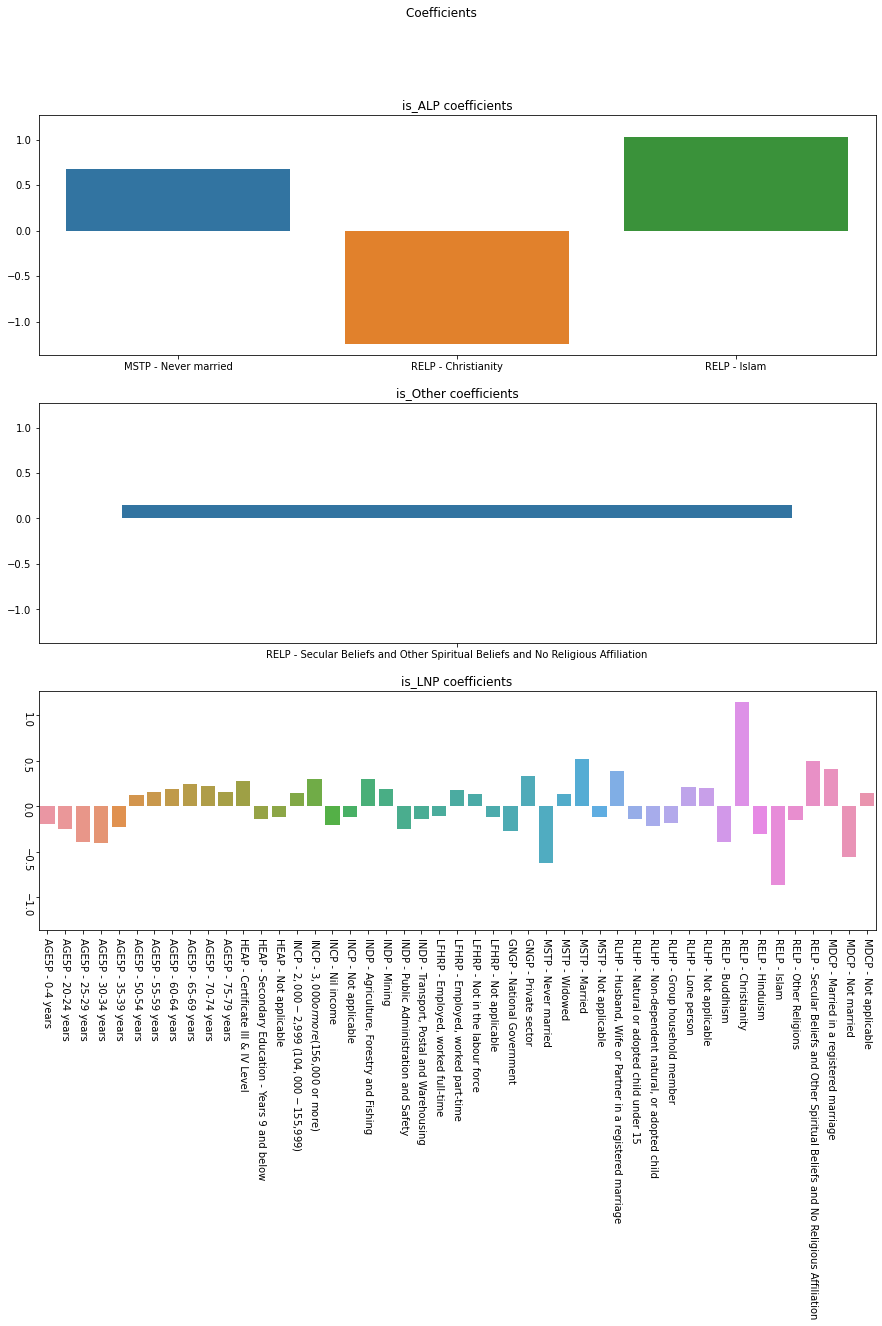

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
fig.suptitle('Coefficients ')
#sns.set_theme(style="whitegrid")

sns.barplot(ax = axes[0], x = list(ALP_coefficient_DF), y = ALP_coefficient_DF.loc[0, :].values.tolist())
axes[0].set_title('is_ALP coefficients')

sns.barplot(ax = axes[1], x = list(Other_coefficient_DF), y = Other_coefficient_DF.loc[0, :].values.tolist())
axes[1].set_title('is_Other coefficients')

sns.barplot(ax = axes[2], x = list(LNP_coefficient_DF), y = LNP_coefficient_DF.loc[0, :].values.tolist())
axes[2].tick_params(labelrotation=-90)
axes[2].set_title('is_LNP coefficients')
plt.show()

## 2) Seat type model

In [42]:
conditions = [(adjusted_master['PreferencePercent'] <= 56),
              ((adjusted_master['PreferencePercent'] > 56) & (adjusted_master['PreferencePercent'] < 60 )
              & (adjusted_master['PartyNm'] == 'LNP')),
              ((adjusted_master['PreferencePercent'] > 56) & (adjusted_master['PreferencePercent'] < 60 )
              & (adjusted_master['PartyNm'] == 'ALP')),
              (adjusted_master['PreferencePercent'] >= 60) & (adjusted_master['PartyNm'] == 'LNP'),
              (adjusted_master['PreferencePercent'] > 56) & (adjusted_master['PartyNm'] == 'ALP'),
             (adjusted_master['PreferencePercent'] > 56) & (adjusted_master['PartyNm'] == 'Other')]

strengths = ['Marginal', 'Fairly Safe LNP', 'Fairly Safe ALP', 'Safe LNP', 'Safe ALP', 'Other']

adjusted_master['Strength'] = np.select(conditions, strengths)
adjusted_master['is_Marginal'] = np.where(adjusted_master['Strength'] == 'Marginal', 1, 0)
adjusted_master['is_Fairly_Safe_ALP'] = np.where(adjusted_master['Strength'] == 'Fairly Safe ALP', 1, 0)
adjusted_master['is_Fairly_Safe_LNP'] = np.where(adjusted_master['Strength'] == 'Fairly Safe LNP', 1, 0)
adjusted_master['is_Safe_ALP'] = np.where(adjusted_master['Strength'] == 'Safe ALP', 1, 0)
adjusted_master['is_Safe_LNP'] = np.where(adjusted_master['Strength'] == 'Safe LNP', 1, 0)
adjusted_master['is_Strength_Other'] = np.where(adjusted_master['Strength'] == 'Other', 1, 0)
adjusted_master

,index,LGA,AGE5P - 0-4 years,AGE5P - 5-9 years,AGE5P - 10-14 years,AGE5P - 15-19 years,AGE5P - 20-24 years,AGE5P - 25-29 years,AGE5P - 30-34 years,AGE5P - 35-39 years,...,is_ALP,is_LNP,is_Other,Strength,is_Marginal,is_Fairly_Safe_ALP,is_Fairly_Safe_LNP,is_Safe_ALP,is_Safe_LNP,is_Strength_Other
0,0,Adelaide,0.053945,0.050723,0.045462,0.057361,0.096777,0.092626,0.088211,0.070221,...,1,0,0,Fairly Safe ALP,0,1,0,0,0,0
1,1,Aston,0.058553,0.058845,0.058346,0.064261,0.066246,0.064391,0.067479,0.066700,...,0,1,0,Safe LNP,0,0,0,0,1,0
2,2,Ballarat,0.062608,0.066055,0.061419,0.062910,0.065860,0.060216,0.059006,0.059537,...,1,0,0,Safe ALP,0,0,0,1,0,0
3,3,Banks,0.060613,0.059368,0.055980,0.060472,0.068598,0.074162,0.073559,0.066018,...,0,1,0,Fairly Safe LNP,0,0,1,0,0,0
4,4,Barker,0.055697,0.063267,0.062771,0.059757,0.050169,0.051558,0.054241,0.054597,...,0,1,0,Safe LNP,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,164,Werriwa,0.072655,0.078559,0.077535,0.077236,0.072380,0.065587,0.071789,0.070232,...,1,0,0,Marginal,1,0,0,0,0,0
147,165,Whitlam,0.060113,0.065839,0.064873,0.066358,0.055673,0.052804,0.056448,0.056678,...,1,0,0,Safe ALP,0,0,0,1,0,0
148,166,Wide Bay,0.048858,0.060062,0.064301,0.056468,0.042020,0.040191,0.044199,0.049902,...,0,1,0,Safe LNP,0,0,0,0,1,0
149,167,Wills,0.062568,0.052921,0.043203,0.043616,0.080062,0.112030,0.108720,0.087122,...,1,0,0,Fairly Safe ALP,0,1,0,0,0,0


In [43]:
train, test = train_test_split(adjusted_master, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(120, 152)
(31, 152)


In [44]:
X_train = train.drop(['index', 'LGA','PartyNm', 'PreferencePercent', 'Strength', 'is_ALP', 'is_LNP', 'is_Other', 'is_Marginal',
                     'is_Fairly_Safe_ALP', 'is_Fairly_Safe_LNP', 'is_Safe_ALP', 'is_Safe_LNP', 'is_Strength_Other'], axis=1)

X_test = test.drop(['index', 'LGA','PartyNm', 'PreferencePercent', 'Strength', 'is_ALP', 'is_LNP', 'is_Other', 'is_Marginal',
                     'is_Fairly_Safe_ALP', 'is_Fairly_Safe_LNP', 'is_Safe_ALP', 'is_Safe_LNP', 'is_Strength_Other'], axis=1)

# Marginal seats
y_train_Marginal = train['is_Marginal']
y_test_Marginal = test['is_Marginal']

# Fairly safe ALP seats
y_train_F_Safe_ALP = train['is_Fairly_Safe_ALP']
y_test_F_Safe_ALP = test['is_Fairly_Safe_ALP']

# Fairly safe LNP seats
y_train_F_Safe_LNP = train['is_Fairly_Safe_LNP']
y_test_F_Safe_LNP = test['is_Fairly_Safe_LNP']

# Safe ALP seats
y_train_Safe_ALP = train['is_Safe_ALP']
y_test_Safe_ALP = test['is_Safe_ALP']

# Safe LNP seats
y_train_Safe_LNP = train['is_Safe_LNP']
y_test_Safe_LNP = test['is_Safe_LNP']

# Other(Strength) seats
y_train_Other_Strength = train['is_Strength_Other']
y_test_Other_Strength = test['is_Strength_Other']

In [45]:
# is_Marginal
Marginal_model = LogisticRegression()
Marginal_model.fit(X_train, y_train_Marginal)
y_hat_train_Marginal = Marginal_model.predict(X_train)
y_hat_test_Marginal = Marginal_model.predict(X_test)
print("Accuracy score on is_Marginal training set: ", accuracy_score(y_train_Marginal, y_hat_train_Marginal))
print("Accuracy score on is_Marginal testing set: ", accuracy_score(y_test_Marginal, y_hat_test_Marginal) , '\n')

# is_fairly_safe_ALP
fairly_safe_ALP_model = LogisticRegression()
fairly_safe_ALP_model.fit(X_train, y_train_F_Safe_ALP)
y_hat_train_F_Safe_ALP = fairly_safe_ALP_model.predict(X_train)
y_hat_test_F_Safe_ALP = fairly_safe_ALP_model.predict(X_test)
print("Accuracy score on is_Fairly_Safe_ALP training set: ", accuracy_score(y_train_F_Safe_ALP, y_hat_train_F_Safe_ALP))
print("Accuracy score on is_Fairly_Safe_ALP testing set: ", accuracy_score(y_test_F_Safe_ALP, y_hat_test_F_Safe_ALP), '\n')

# is_fairly_safe_LNP
fairly_safe_LNP_model = LogisticRegression()
fairly_safe_LNP_model.fit(X_train, y_train_F_Safe_LNP)
y_hat_train_F_Safe_LNP = fairly_safe_LNP_model.predict(X_train)
y_hat_test_F_Safe_LNP = fairly_safe_LNP_model.predict(X_test)
print("Accuracy score on is_Fairly_Safe_LNP training set: ", accuracy_score(y_train_F_Safe_LNP, y_hat_train_F_Safe_LNP))
print("Accuracy score on is_Fairly_Safe_LNP testing set: ", accuracy_score(y_test_F_Safe_LNP, y_hat_test_F_Safe_LNP), '\n')

# is_safe_ALP
Safe_ALP_model = LogisticRegression()
Safe_ALP_model.fit(X_train, y_train_Safe_ALP)
y_hat_train_Safe_ALP = Safe_ALP_model.predict(X_train)
y_hat_test_Safe_ALP = Safe_ALP_model.predict(X_test)
print("Accuracy score on is_Safe_ALP training set: ", accuracy_score(y_train_Safe_ALP, y_hat_train_Safe_ALP))
print("Accuracy score on is_Safe_ALP testing set: ", accuracy_score(y_test_Safe_ALP, y_hat_test_Safe_ALP) , '\n')

# is_safe_LNP
Safe_LNP_model = LogisticRegression()
Safe_LNP_model.fit(X_train, y_train_Safe_LNP)
y_hat_train_Safe_LNP = Safe_LNP_model.predict(X_train)
y_hat_test_Safe_LNP = Safe_LNP_model.predict(X_test)
print("Accuracy score on is_Safe_LNP training set: ", accuracy_score(y_train_Safe_LNP, y_hat_train_Safe_LNP))
print("Accuracy score on is_Safe_LNP testing set: ", accuracy_score(y_test_Safe_LNP, y_hat_test_Safe_LNP), '\n')

# is_Other_strength
Other_Strength_model = LogisticRegression()
Other_Strength_model.fit(X_train, y_train_Other_Strength)
y_hat_train_Other_Strength = Other_Strength_model.predict(X_train)
y_hat_test_Other_Strength = Other_Strength_model.predict(X_test)
print("Accuracy score on is_Other_Strength training set: ", accuracy_score(y_train_Other_Strength, y_hat_train_Other_Strength))
print("Accuracy score on is_Other_Strength testing set: ", accuracy_score(y_test_Other_Strength, y_hat_test_Other_Strength))

Accuracy score on is_Marginal training set:  0.7
Accuracy score on is_Marginal testing set:  0.6129032258064516 

Accuracy score on is_Fairly_Safe_ALP training set:  0.8833333333333333
Accuracy score on is_Fairly_Safe_ALP testing set:  0.8709677419354839 

Accuracy score on is_Fairly_Safe_LNP training set:  0.9
Accuracy score on is_Fairly_Safe_LNP testing set:  0.8387096774193549 

Accuracy score on is_Safe_ALP training set:  0.8166666666666667
Accuracy score on is_Safe_ALP testing set:  0.9032258064516129 

Accuracy score on is_Safe_LNP training set:  0.725
Accuracy score on is_Safe_LNP testing set:  0.8064516129032258 

Accuracy score on is_Other_Strength training set:  0.975
Accuracy score on is_Other_Strength testing set:  0.967741935483871


## Feature selection by RFE (Seat Type Model)

In [46]:
# Lists containing the accuracy score of the best model for that amount of columns
# Example, Marginal_acc_scores[n] will have the accuracy of the best 'is_Marginal' model with n+1 columns  
Marginal_acc_scores = []
F_Safe_ALP_acc_scores = []
F_Safe_LNP_acc_scores = []
Safe_ALP_acc_scores = []
Safe_LNP_acc_scores = []
Other_Strength_acc_scores = []

for i in range(1,140):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    
    # Determining is_Marginal best fit model with the least amount of variables
    rfe.fit(X_train, y_train_Marginal)
    Marginal_y_pred = rfe.predict(X_test)
    Marginal_acc_score = accuracy_score(y_test_Marginal, Marginal_y_pred)
    Marginal_acc_scores.append(Marginal_acc_score)
    
    # Determining is_Fairly_Safe_ALP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_F_Safe_ALP)
    F_Safe_ALP_y_pred = rfe.predict(X_test)
    F_Safe_ALP_acc_score = accuracy_score(y_test_F_Safe_ALP, F_Safe_ALP_y_pred)
    F_Safe_ALP_acc_scores.append(F_Safe_ALP_acc_score)
    
    # Determining is_Fairly_Safe_LNP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_F_Safe_LNP)
    F_Safe_LNP_y_pred = rfe.predict(X_test)
    F_Safe_LNP_acc_score = accuracy_score(y_test_F_Safe_LNP, F_Safe_LNP_y_pred)
    F_Safe_LNP_acc_scores.append(F_Safe_LNP_acc_score)
    
    # Determining is_Safe_ALP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_Safe_ALP)
    Safe_ALP_y_pred = rfe.predict(X_test)
    Safe_ALP_acc_score = accuracy_score(y_test_Safe_ALP, Safe_ALP_y_pred)
    Safe_ALP_acc_scores.append(Safe_ALP_acc_score)
    
    # Determining is_Safe_LNP's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_Safe_LNP)
    Safe_LNP_y_pred = rfe.predict(X_test)
    Safe_LNP_acc_score = accuracy_score(y_test_Safe_LNP, Safe_LNP_y_pred)
    Safe_LNP_acc_scores.append(Safe_LNP_acc_score)
    
    # Determining is_Other)Strength's best fit model with the least amount of variables
    rfe.fit(X_train, y_train_Other_Strength)
    Other_Strength_y_pred = rfe.predict(X_test)
    Other_Strength_acc_score = accuracy_score(y_test_Other_Strength, Other_Strength_y_pred)
    Other_Strength_acc_scores.append(Other_Strength_acc_score)
      
# Marginal    
Marginal_best = Marginal_acc_scores[0]
Marginal_best_number_of_columns = 0;

# Fairly Safe ALP
F_Safe_ALP_best = F_Safe_ALP_acc_scores[0]
F_Safe_ALP_best_number_of_columns = 0;

# Fairly Safe LNP
F_Safe_LNP_best = F_Safe_LNP_acc_scores[0]
F_Safe_LNP_best_number_of_columns = 0;

# Safe ALP    
Safe_ALP_best = Safe_ALP_acc_scores[0]
Safe_ALP_best_number_of_columns = 0;

# Safe LNP
Safe_LNP_best = Safe_LNP_acc_scores[0]
Safe_LNP_best_number_of_columns = 0;

# Other Strength
Other_Strength_best = Other_Strength_acc_scores[0]
Other_Strength_best_number_of_columns = 0;

for i in range(len(Marginal_acc_scores)):
    if Marginal_acc_scores[i] > Marginal_best:
        Marginal_best = Marginal_acc_scores[i]
        Marginal_best_number_of_columns = i
        
    if F_Safe_ALP_acc_scores[i] > F_Safe_ALP_best:
        F_Safe_ALP_best = F_Safe_ALP_acc_scores[i]
        F_Safe_ALP_best_number_of_columns = i   
        
    if F_Safe_LNP_acc_scores[i] > F_Safe_LNP_best:
        F_Safe_LNP_best = F_Safe_LNP_acc_scores[i]
        F_Safe_LNP_best_number_of_columns = i          

    if Safe_ALP_acc_scores[i] > Safe_ALP_best:
        Safe_ALP_best = Safe_ALP_acc_scores[i]
        Safe_ALP_best_number_of_columns = i
        
    if Safe_LNP_acc_scores[i] > Safe_LNP_best:
        Safe_LNP_best = Safe_LNP_acc_scores[i]
        Safe_LNP_best_number_of_columns = i   
        
    if Other_Strength_acc_scores[i] > Other_Strength_best:
        Other_Strength_best = Other_Strength_acc_scores[i]
        Other_Strength_best_number_of_columns = i 
        
print('For is_Marginal', Marginal_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (Marginal_best*100), "%") 
print('For is_Fairly_Safe_ALP', F_Safe_ALP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (F_Safe_ALP_best*100), "%")
print('For is_Fairly_Safe_LNP', F_Safe_LNP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (F_Safe_LNP_best*100), "%")
print('For is_Safe_ALP', Safe_ALP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (Safe_ALP_best*100), "%") 
print('For is_Safe_LNP', Safe_LNP_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (Safe_LNP_best*100), "%")
print('For is_Other_Strength', Other_Strength_best_number_of_columns + 1, 'columns provide the highest accuracy at: %.2f' % (Other_Strength_best*100), "%")

For is_Marginal 1 columns provide the highest accuracy at: 61.29 %
For is_Fairly_Safe_ALP 1 columns provide the highest accuracy at: 87.10 %
For is_Fairly_Safe_LNP 1 columns provide the highest accuracy at: 83.87 %
For is_Safe_ALP 1 columns provide the highest accuracy at: 90.32 %
For is_Safe_LNP 1 columns provide the highest accuracy at: 80.65 %
For is_Other_Strength 1 columns provide the highest accuracy at: 96.77 %


## Note

We get the same accuracy from the models if we increase the number of variables to 5, plus doing so provides us with list of the top five most important demographics.

In [47]:
print("is_Marginal with 5 columns provides an accuracy of: %.2f" % (Marginal_acc_scores[4]*100), '%')
print("is_Fairly_Safe_ALP with 5 columns provides an accuracy of: %.2f" % (F_Safe_ALP_acc_scores[4]*100), '%')
print("is_Fairly_Safe_LNP with 5 columns provides an accuracy of: %.2f" % (F_Safe_LNP_acc_scores[4]*100), '%')
print("is_Safe_ALP with 5 columns provides an accuracy of: %.2f" % (Safe_ALP_acc_scores[4]*100), '%')
print("is_Safe_LNP with 5 columns provides an accuracy of: %.2f" % (Safe_LNP_acc_scores[4]*100), '%')
print("is_Other_Strength with 5 columns provides an accuracy of: %.2f" % (Other_Strength_acc_scores[4]*100), '%')

is_Marginal with 5 columns provides an accuracy of: 61.29 %
is_Fairly_Safe_ALP with 5 columns provides an accuracy of: 87.10 %
is_Fairly_Safe_LNP with 5 columns provides an accuracy of: 83.87 %
is_Safe_ALP with 5 columns provides an accuracy of: 90.32 %
is_Safe_LNP with 5 columns provides an accuracy of: 80.65 %
is_Other_Strength with 5 columns provides an accuracy of: 96.77 %


## Retrieving the variables from the best models 

In [48]:
# is_Marginal
lr_model_Marginal = LogisticRegression()
rfe = RFE(estimator=lr_model_Marginal, n_features_to_select= 5, step=1)
rfe.fit(X_train, y_train_Marginal)
Marginal_y_test_hat = rfe.predict(X_test)

Marginal_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        Marginal_relevant_cols.append(i)

Marginal_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)      
        
        
# is_Fairly_Safe_ALP
lr_model_F_Safe_ALP = LogisticRegression()
rfe = RFE(estimator=lr_model_F_Safe_ALP, n_features_to_select= 5, step=1)
rfe.fit(X_train, y_train_F_Safe_ALP)
F_Safe_ALP_y_test_hat = rfe.predict(X_test)

F_Safe_ALP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        F_Safe_ALP_relevant_cols.append(i)

F_Safe_ALP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)       
        
# is_Fairly_Safe_LNP
lr_model_F_Safe_LNP = LogisticRegression()
rfe = RFE(estimator=lr_model_F_Safe_LNP, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train_F_Safe_LNP)
F_Safe_LNP_y_test_hat = rfe.predict(X_test)


F_Safe_LNP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        F_Safe_LNP_relevant_cols.append(i)
        
F_Safe_LNP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_) 

# is_Safe_ALP
lr_model_Safe_ALP = LogisticRegression()
rfe = RFE(estimator=lr_model_Safe_ALP, n_features_to_select= 5, step=1)
rfe.fit(X_train, y_train_Safe_ALP)
Safe_ALP_y_test_hat = rfe.predict(X_test)

Safe_ALP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        Safe_ALP_relevant_cols.append(i)

Safe_ALP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)      
        
        
# is_Safe_LNP
lr_model_Safe_LNP = LogisticRegression()
rfe = RFE(estimator=lr_model_Safe_LNP, n_features_to_select= 5, step=1)
rfe.fit(X_train, y_train_Safe_LNP)
Safe_LNP_y_test_hat = rfe.predict(X_test)

Safe_LNP_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        Safe_LNP_relevant_cols.append(i)

Safe_LNP_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_)       
        
# Other
lr_model_Other_Strength = LogisticRegression()
rfe = RFE(estimator=lr_model_Other_Strength, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train_Other_Strength)
Other_Strength_y_test_hat = rfe.predict(X_test)


Other_Strength_relevant_cols = []
for i in range(X_train.shape[1]):
    if rfe.support_[i] == True:
        Other_Strength_relevant_cols.append(i)
        
Other_Strength_coefficient_DF = pd.DataFrame(list(map(np.ravel, rfe.estimator_.coef_)), columns=X_train.columns[rfe.support_], index=rfe.estimator_.classes_) 

## Most important coefficients graph (Seat type model)

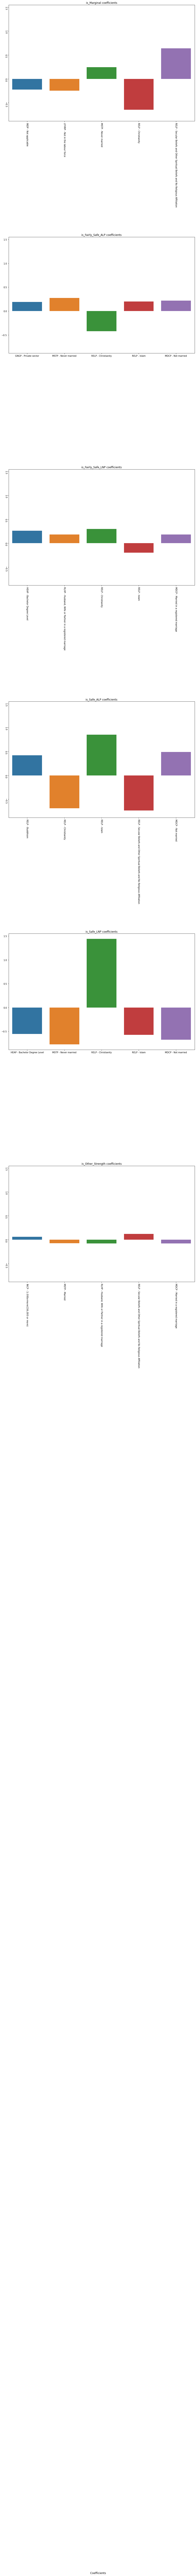

In [49]:
fig, axes = plt.subplots(6, 1, figsize=(15, 40), sharey=True)
fig.suptitle('Coefficients ')
plt.subplots_adjust(left=None, bottom=3, right=None, top=5, wspace=None, hspace=1)
#sns.set_theme(style="whitegrid")

sns.barplot(ax = axes[0], x = list(Marginal_coefficient_DF), y = Marginal_coefficient_DF.loc[0, :].values.tolist())
axes[0].tick_params(labelrotation=-90)
axes[0].set_title('is_Marginal coefficients')

sns.barplot(ax = axes[1], x = list(F_Safe_ALP_coefficient_DF), y = F_Safe_ALP_coefficient_DF.loc[0, :].values.tolist())
axes[1].set_title('is_Fairly_Safe_ALP coefficients')

sns.barplot(ax = axes[2], x = list(F_Safe_LNP_coefficient_DF), y = F_Safe_LNP_coefficient_DF.loc[0, :].values.tolist())
axes[2].tick_params(labelrotation=-90)
axes[2].set_title('is_Fairly_Safe_LNP coefficients')

sns.barplot(ax = axes[3], x = list(Safe_ALP_coefficient_DF), y = Safe_ALP_coefficient_DF.loc[0, :].values.tolist())
axes[3].tick_params(labelrotation=-90)
axes[3].set_title('is_Safe_ALP coefficients')

sns.barplot(ax = axes[4], x = list(Safe_LNP_coefficient_DF), y = Safe_LNP_coefficient_DF.loc[0, :].values.tolist())
axes[4].set_title('is_Safe_LNP coefficients')

sns.barplot(ax = axes[5], x = list(Other_Strength_coefficient_DF), y = Other_Strength_coefficient_DF.loc[0, :].values.tolist())
axes[5].tick_params(labelrotation=-90)
axes[5].set_title('is_Other_Strength coefficients')
plt.show()

# Non-regression Models

The following types of non-regression models were also tested for their effectiveness in building a voting predictive model:

 - K-Nearest Neighbours
 - Decision Tree
 - Random Forest
 - Multi-layer Perceptron

For these model types, we only examined the accuracy of predicting victory in each electorate and did not examine the effects of party strength in a particular seat.

In [50]:
all_df_norm_major_groups = all_df_norm.copy()
all_df_norm_major_groups['PartyNm'].replace('Labor', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Australian Labor Party (Northern Territory) Branch', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Australian Labor Party', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Independent', 'Other', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Katter\'s Australian Party (KAP)', 'Other', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('The Greens (VIC)', 'Other', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Centre Alliance', 'Other', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Liberal National Party of Queensland', 'LNP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Liberal', 'LNP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('The Nationals', 'LNP', inplace=True)
set(all_df_norm_major_groups['PartyNm'])

{'ALP', 'LNP', 'Other'}

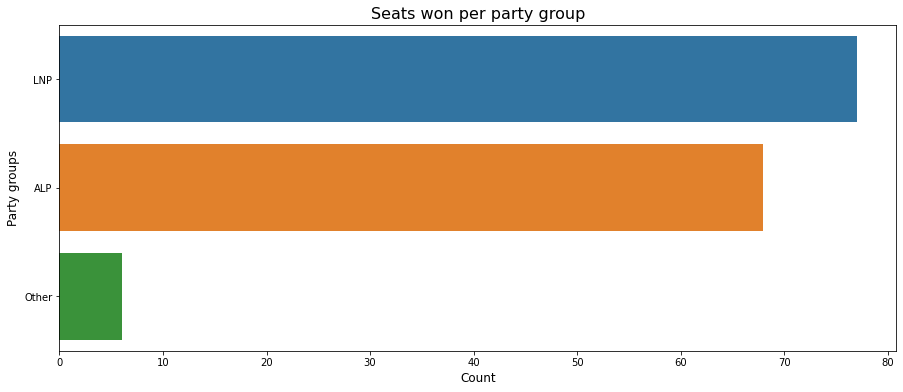

In [51]:
grouped_party_total = all_df_norm_major_groups['PartyNm'].value_counts().reset_index().set_axis(['x', 'y'], axis='columns')

plt.figure(figsize=(15,6))
sns.barplot(data=grouped_party_total, y='x', x='y', palette='tab10')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Party groups', fontsize=12)
plt.title("Seats won per party group", fontsize=16)
plt.show()

After grouping, the difference between the number of seats won by the Coalition compared to the Labor Party. As previously observed, the Coalition won the election with 77 seats compared to Labor's 68 seats.

### KNN Analysis

In [52]:
X = all_df_norm_major_groups.drop(columns=['PreferencePercent', 'PartyNm'])
y = all_df_norm_major_groups['PartyNm']
train, test = train_test_split(all_df_norm_major_groups, test_size=0.2, random_state=42)
train_X = train.drop(columns=['PreferencePercent','PartyNm'])
train_y = train['PartyNm']
test_X = test.drop(columns=['PreferencePercent','PartyNm'])
test_y = test['PartyNm']

In [53]:
parameter_grid = {
    'n_neighbors': range(1,21)
}
knn_grid = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_knn.fit(X, y)
print('Best values:')
for key, value in gs_knn.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('Accuracy: %.4f\n' % gs_knn.best_score_)

Best values:
Best value for "n_neighbors": 7
Accuracy: 0.7496



In [54]:
gs_knn_result = pd.DataFrame(gs_knn.cv_results_)
gs_knn_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.003600,0.000663,0.003900,0.000700,7,{'n_neighbors': 7},0.5625,0.666667,0.866667,0.800000,0.800000,0.733333,0.866667,0.733333,0.733333,0.733333,0.749583,0.086852,1
4,0.003758,0.000399,0.004101,0.000538,5,{'n_neighbors': 5},0.5625,0.733333,0.866667,0.666667,0.800000,0.866667,0.800000,0.800000,0.600000,0.666667,0.736250,0.102301,2
2,0.003129,0.000702,0.003371,0.000783,3,{'n_neighbors': 3},0.6250,0.733333,0.800000,0.666667,0.866667,0.733333,0.800000,0.800000,0.600000,0.733333,0.735833,0.080627,3
5,0.003368,0.000641,0.004051,0.000782,6,{'n_neighbors': 6},0.5625,0.666667,0.866667,0.666667,0.733333,0.866667,0.800000,0.800000,0.600000,0.666667,0.722917,0.101811,4
10,0.003451,0.000472,0.003800,0.000600,11,{'n_neighbors': 11},0.5000,0.666667,0.800000,0.666667,0.866667,0.800000,0.800000,0.666667,0.600000,0.800000,0.716667,0.108781,5
11,0.003499,0.000671,0.004000,0.000633,12,{'n_neighbors': 12},0.5000,0.600000,0.733333,0.733333,0.800000,0.800000,0.800000,0.800000,0.666667,0.733333,0.716667,0.095743,5
15,0.003099,0.000700,0.003452,0.000569,16,{'n_neighbors': 16},0.5000,0.666667,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.666667,0.866667,0.710000,0.086987,7
14,0.003600,0.000663,0.003700,0.000901,15,{'n_neighbors': 15},0.5000,0.666667,0.800000,0.666667,0.800000,0.666667,0.800000,0.733333,0.666667,0.800000,0.710000,0.091954,7
13,0.003400,0.000664,0.003400,0.000663,14,{'n_neighbors': 14},0.5000,0.666667,0.733333,0.666667,0.800000,0.733333,0.800000,0.733333,0.666667,0.800000,0.710000,0.086987,7
3,0.003800,0.000400,0.003800,0.000400,4,{'n_neighbors': 4},0.5625,0.600000,0.866667,0.600000,0.733333,0.800000,0.866667,0.800000,0.600000,0.666667,0.709583,0.112145,10


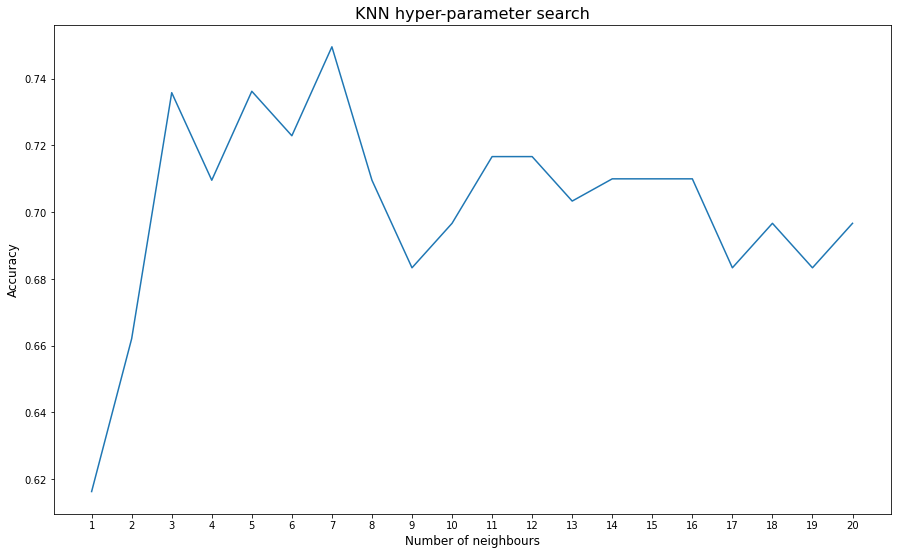

In [55]:
plt.figure(figsize=(15,9))
sns.lineplot(x=(gs_knn_result['param_n_neighbors'].apply(lambda x: str(x))), y=gs_knn_result['mean_test_score'])
plt.xlabel('Number of neighbours', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("KNN hyper-parameter search", fontsize=16)
plt.show()

The highest overall accuracy was achieved with KNN models using 7 nearest neighbours. It can be seen that very low values for n_neighbors (1 or 2) has a detrimental effect on accuracy, likely due to overfitting. The model accuracy peaks when 7 neighbors are used for prediction, after which the model accuracy steadily decreases as n_neighbors increases, likely due to underfitting and over-generalisation.

In [56]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=7)

In [57]:
print("Training accuracy:", accuracy_score(train_y, knn.predict(train_X)))
print("Test accuracy:", accuracy_score(test_y, knn.predict(test_X)))

Training accuracy: 0.8166666666666667
Test accuracy: 0.6451612903225806


In [58]:
knn_result = pd.DataFrame(test['PartyNm'])
knn_result.columns = ["Actual"]
knn_result.insert(1, "Predicted", knn.predict(test_X))
knn_result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(knn_result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,LNP,LNP,59.85
Brand,ALP,LNP,56.66
Kennedy,Other,LNP,63.33
Jagajaga,ALP,LNP,56.57
Warringah,Other,LNP,57.24
Cook,LNP,LNP,69.02
Hunter,ALP,ALP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


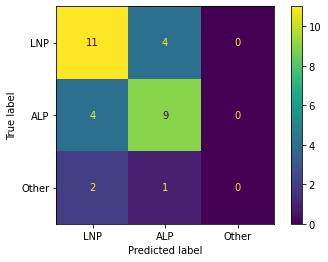

In [59]:
ConfusionMatrixDisplay(confusion_matrix(knn_result.iloc[:,0],knn_result.iloc[:,1],
                                        labels=["LNP", "ALP", "Other"]),
                                        display_labels=["LNP", "ALP", "Other"]).plot()
plt.show()

The KNN model performed reasonably well at predicting the outcomes of elections where the two major parties (LNP and ALP) won. However, the model was unable to correctly predict any of the electorates where minor parties or independents ended up winning.

### Decision Tree

In [60]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 16),
}
dt_grid = DecisionTreeClassifier(random_state=42)
gs_dt = GridSearchCV(dt_grid, parameter_grid, scoring='accuracy', n_jobs=4, cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_dt.fit(X, y)
print('Best values:')
for key, value in gs_dt.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_dt.best_score_)

Best values:
Best value for "criterion": gini
Best value for "max_depth": 3
Best value for "splitter": best
The accuracy: 0.7371



In [61]:
gs_dt_result = pd.DataFrame(gs_dt.cv_results_)
gs_dt_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
4,0.005699,0.000458,0.002201,0.000400,gini,3,best,"{'criterion': 'gini', 'max_depth': 3, 'splitte...",0.4375,0.666667,...,0.866667,0.733333,0.800000,0.733333,0.800000,0.666667,0.866667,0.737083,0.120480,1
6,0.007698,0.001552,0.002601,0.000917,gini,4,best,"{'criterion': 'gini', 'max_depth': 4, 'splitte...",0.4375,0.800000,...,0.666667,0.733333,0.733333,0.733333,0.800000,0.666667,0.866667,0.723750,0.112516,2
3,0.002700,0.000641,0.001700,0.000458,gini,2,random,"{'criterion': 'gini', 'max_depth': 2, 'splitte...",0.4375,0.600000,...,0.733333,0.666667,0.800000,0.733333,0.733333,0.733333,0.866667,0.717083,0.121284,3
42,0.014452,0.002833,0.002400,0.000490,entropy,7,best,"{'criterion': 'entropy', 'max_depth': 7, 'spli...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.709583,0.158180,4
2,0.004599,0.000489,0.002100,0.000539,gini,2,best,"{'criterion': 'gini', 'max_depth': 2, 'splitte...",0.5000,0.600000,...,0.800000,0.800000,0.600000,0.600000,0.733333,0.666667,0.800000,0.703333,0.125122,5
52,0.014499,0.002335,0.002352,0.000896,entropy,12,best,"{'criterion': 'entropy', 'max_depth': 12, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
54,0.014251,0.002018,0.002200,0.000600,entropy,13,best,"{'criterion': 'entropy', 'max_depth': 13, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
46,0.014588,0.002812,0.002506,0.000506,entropy,9,best,"{'criterion': 'entropy', 'max_depth': 9, 'spli...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
56,0.013005,0.002016,0.002205,0.000599,entropy,14,best,"{'criterion': 'entropy', 'max_depth': 14, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
48,0.015151,0.002741,0.002500,0.000671,entropy,10,best,"{'criterion': 'entropy', 'max_depth': 10, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6


In [62]:
dt_result_plot = pd.DataFrame(columns=['params', 'values'])
dt_result_plot['params'] = gs_dt_result['param_criterion'] + ' ' + gs_dt_result['param_splitter'] + ' ' + gs_dt_result['param_max_depth'].apply(lambda x: str(x))
dt_result_plot['values'] = gs_dt_result['mean_test_score']
dt_result_plot

,params,values
0,gini best 1,0.623333
1,gini random 1,0.690000
2,gini best 2,0.703333
3,gini random 2,0.717083
4,gini best 3,0.737083
5,gini random 3,0.690000
6,gini best 4,0.723750
7,gini random 4,0.624167
8,gini best 5,0.684167
9,gini random 5,0.610000


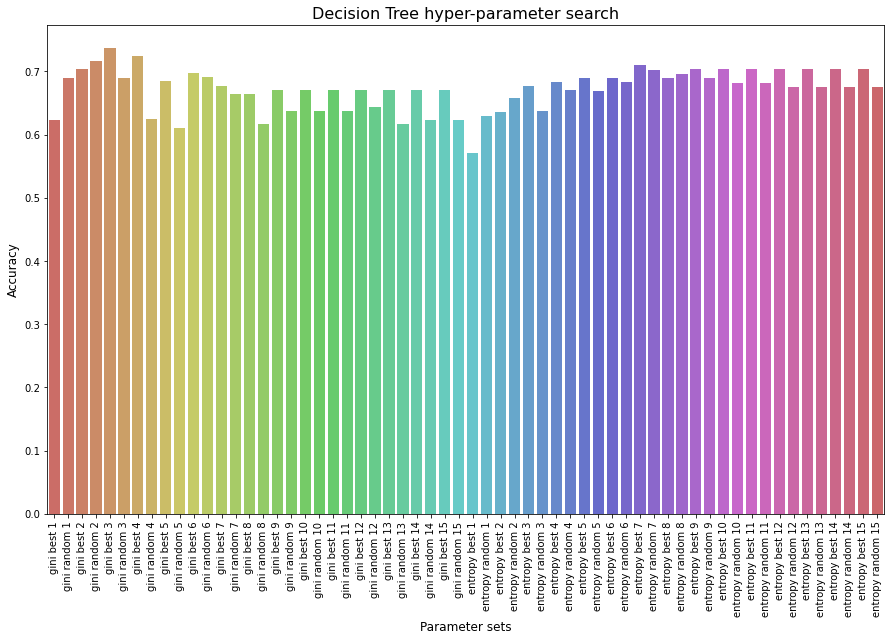

In [63]:
plt.figure(figsize=(15,9))
sns.barplot(data=dt_result_plot, x='params', y='values', palette='hls')
plt.xticks(rotation=90)
plt.xlabel('Parameter sets', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Decision Tree hyper-parameter search", fontsize=16)
plt.show()

The Decision Tree model that resulted in the highest mean accuracy had a mean accuracy of 73.71% and was built using the following hyper-parameters:

 - Criterion: gini
 - Maximum depth: 3
 - Splitter: best

In [64]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3, criterion='gini', splitter='best')
dt.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [65]:
print(accuracy_score(train_y, dt.predict(train_X)))
print(accuracy_score(test_y, dt.predict(test_X)))

0.9083333333333333
0.5806451612903226


In [66]:
dt_result = pd.DataFrame(test['PartyNm'])
dt_result.columns = ["Actual"]
dt_result.insert(1, "Predicted", dt.predict(test_X))
dt_result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(dt_result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,LNP,LNP,59.85
Brand,ALP,ALP,56.66
Kennedy,Other,LNP,63.33
Jagajaga,ALP,LNP,56.57
Warringah,Other,ALP,57.24
Cook,LNP,LNP,69.02
Hunter,ALP,ALP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,LNP,63.99


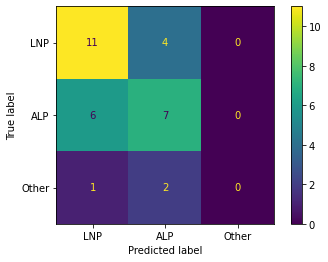

In [67]:
ConfusionMatrixDisplay(confusion_matrix(dt_result.iloc[:,0],dt_result.iloc[:,1],
                                        labels=["LNP", "ALP", "Other"]),
                                        display_labels=["LNP", "ALP", "Other"]).plot()
plt.show()

While the overall accuracy of the Decision Tree model was reasonably high, based on the confusion matrix, the model's capacity to predict voting outcomes in non-LNP seats is quite poor. Prediction accuracy for ALP seats was only slightly better than 50-50 and electorates where minor parties and independents won could not be predicted at all.

### Random Forest

In [68]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50, 301, 25)
}
rf_grid = RandomForestClassifier(random_state=42)
gs_rf = GridSearchCV(rf_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_rf.fit(X, y)
print('Best values:')
for key, value in gs_rf.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_rf.best_score_)

Best values:
Best value for "criterion": entropy
Best value for "n_estimators": 75
The accuracy: 0.7696



In [69]:
gs_rf_result = pd.DataFrame(gs_rf.cv_results_)
gs_rf_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
12,0.105995,0.006031,0.007205,0.000606,entropy,75,"{'criterion': 'entropy', 'n_estimators': 75}",0.5625,0.866667,0.800000,0.800000,0.733333,0.733333,0.733333,0.800000,0.800000,0.866667,0.769583,0.083293,1
15,0.212491,0.012438,0.011914,0.001222,entropy,150,"{'criterion': 'entropy', 'n_estimators': 150}",0.5625,0.800000,0.800000,0.800000,0.666667,0.733333,0.733333,0.866667,0.800000,0.866667,0.762917,0.088436,2
10,0.332741,0.008537,0.021905,0.001986,gini,300,"{'criterion': 'gini', 'n_estimators': 300}",0.5000,0.733333,0.800000,0.800000,0.600000,0.800000,0.733333,0.866667,0.800000,0.933333,0.756667,0.119304,3
16,0.236885,0.007623,0.013304,0.000655,entropy,175,"{'criterion': 'entropy', 'n_estimators': 175}",0.5625,0.800000,0.733333,0.800000,0.666667,0.733333,0.733333,0.866667,0.800000,0.866667,0.756250,0.087901,4
13,0.140515,0.003787,0.008703,0.001184,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.5000,0.800000,0.733333,0.800000,0.666667,0.800000,0.733333,0.800000,0.800000,0.866667,0.750000,0.098036,5
9,0.308485,0.015701,0.019607,0.000788,gini,275,"{'criterion': 'gini', 'n_estimators': 275}",0.5000,0.733333,0.800000,0.800000,0.600000,0.800000,0.733333,0.866667,0.800000,0.866667,0.750000,0.110805,5
1,0.089791,0.005757,0.007446,0.001384,gini,75,"{'criterion': 'gini', 'n_estimators': 75}",0.5625,0.800000,0.800000,0.733333,0.600000,0.733333,0.733333,0.866667,0.800000,0.866667,0.749583,0.096545,7
6,0.228001,0.010384,0.015895,0.002176,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.5625,0.733333,0.800000,0.800000,0.533333,0.733333,0.733333,0.866667,0.800000,0.933333,0.749583,0.117326,7
11,0.070361,0.004763,0.005303,0.000450,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.6250,0.666667,0.800000,0.733333,0.733333,0.800000,0.666667,0.800000,0.800000,0.866667,0.749167,0.073262,9
19,0.339466,0.009534,0.017629,0.000468,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.5000,0.800000,0.666667,0.800000,0.666667,0.733333,0.733333,0.866667,0.800000,0.866667,0.743333,0.105462,10


In [70]:
rf_result_plot = pd.DataFrame(columns=['params', 'values'])
rf_result_plot['params'] = gs_rf_result['param_criterion'] + ' ' + gs_rf_result['param_n_estimators'].apply(lambda x: str(x))
rf_result_plot['values'] = gs_rf_result['mean_test_score']
rf_result_plot

,params,values
0,gini 50,0.742500
1,gini 75,0.749583
2,gini 100,0.742917
3,gini 125,0.736250
4,gini 150,0.729583
5,gini 175,0.742917
6,gini 200,0.749583
7,gini 225,0.736250
8,gini 250,0.736667
9,gini 275,0.750000


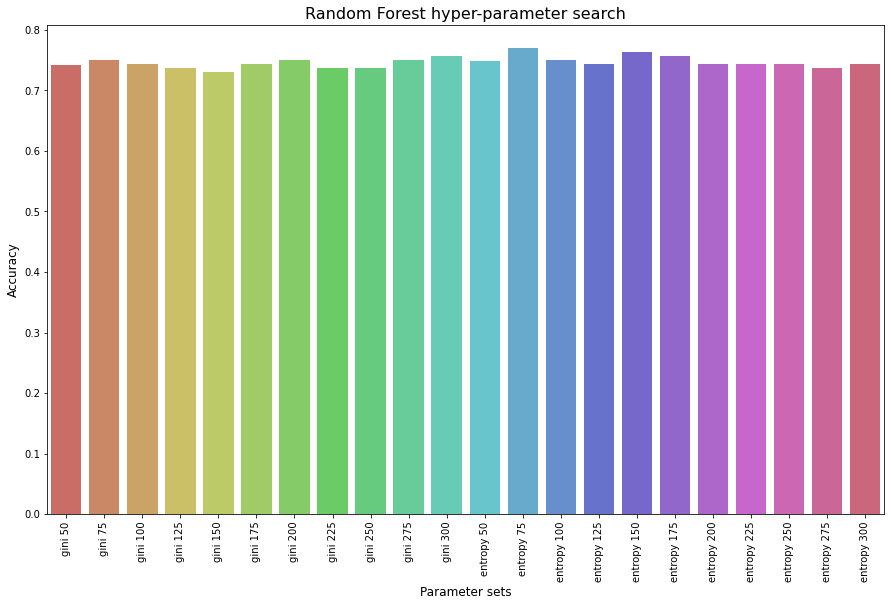

In [71]:
plt.figure(figsize=(15,9))
sns.barplot(data=rf_result_plot, x='params', y='values', palette='hls')
plt.xticks(rotation=90)
plt.xlabel('Parameter sets', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Random Forest hyper-parameter search", fontsize=16)
plt.show()

The Random Forest model with the highest mean accuracy had a mean accuracy of 76.96% and was built using the following hyper-parameters:

 - Criterion: entropy
 - Number of estimators: 75

In [72]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=75)
rf.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=75, random_state=42)

In [73]:
print(accuracy_score(train_y, rf.predict(train_X)))
print(accuracy_score(test_y, rf.predict(test_X)))

1.0
0.6774193548387096


In [74]:
rf_result = pd.DataFrame(test['PartyNm'])
rf_result.columns = ["Actual"]
rf_result.insert(1, "Predicted", rf.predict(test_X))
rf_result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(rf_result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,LNP,LNP,59.85
Brand,ALP,ALP,56.66
Kennedy,Other,LNP,63.33
Jagajaga,ALP,LNP,56.57
Warringah,Other,LNP,57.24
Cook,LNP,LNP,69.02
Hunter,ALP,LNP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


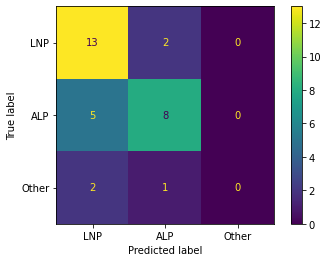

In [75]:
ConfusionMatrixDisplay(confusion_matrix(rf_result.iloc[:,0],rf_result.iloc[:,1],
                                        labels=["LNP", "ALP", "Other"]),
                                        display_labels=["LNP", "ALP", "Other"]).plot()
plt.show()

The "best" Random Forest model had a mean prediction accuracy of 76.96% compared to the "best" Decision Tree model with a mean accuracy of 73.71%. This is expected since Random Forest models are often used to overcome the overfitting issues of Decision Trees alone.

The Random Forest model appears to be biased more towards LNP compared to ALP, possibly due to there being more LNP seats in the data. This model also was unable to predict the electoral outcomes in any electorate won by a minor party or independent candidate.

### Multi-layer Perceptron model

In [76]:
parameter_grid = {
    'hidden_layer_sizes': [[100], [200], [300], [100, 100], [200, 200], [300, 300]],
    'solver': ['lbfgs', 'adam'],
    'activation': ['identity', 'tanh', 'relu']
}
mlp_grid = MLPClassifier(max_iter=10000, random_state=42)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', n_jobs=4, cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=MLPClassifier(max_iter=10000, random_state=42), n_jobs=4,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'hidden_layer_sizes': [[100], [200], [300], [100, 100],
                                                [200, 200], [300, 300]],
                         'solver': ['lbfgs', 'adam']},
             scoring='accuracy')

In [77]:
gs_mlp_result = pd.DataFrame(gs_mlp.cv_results_)
gs_mlp_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
21,1.954092,0.255793,0.004063,0.000569,tanh,"[200, 200]",adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.800000,0.800000,0.800000,0.800000,0.933333,0.600000,0.933333,0.795833,0.105096,1
5,3.466704,0.285731,0.004198,0.000602,identity,[300],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.866667,0.866667,0.666667,0.933333,0.795833,0.091534,1
15,3.193955,0.194019,0.003999,0.000003,tanh,[200],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.866667,0.866667,0.666667,0.933333,0.795833,0.091534,1
1,1.818017,0.149690,0.003640,0.000453,identity,[100],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.789167,0.088510,4
13,2.244062,0.148504,0.003851,0.000451,tanh,[100],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.789167,0.088510,4
25,2.695600,0.164227,0.003700,0.000459,relu,[100],adam,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.933333,0.666667,0.933333,0.789167,0.098040,4
27,4.194769,0.276204,0.004142,0.000302,relu,[200],adam,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.782500,0.089942,7
3,2.806978,0.201047,0.004100,0.000300,identity,[200],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.800000,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.782500,0.084857,7
23,3.471467,0.550609,0.004300,0.000458,tanh,"[300, 300]",adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.800000,0.800000,0.800000,0.733333,0.866667,0.666667,0.933333,0.775833,0.085833,9
17,4.255070,0.484403,0.004200,0.000398,tanh,[300],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.733333,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.775833,0.090864,9


In [78]:
result_plot = pd.DataFrame(columns=['params', 'values'])
result_plot['params'] = gs_mlp_result['param_activation'] + ' ' + gs_mlp_result['param_solver'] + ' ' + gs_mlp_result['param_hidden_layer_sizes'].apply(lambda x: str(x))
result_plot['values'] = gs_mlp_result['mean_test_score']
result_plot

,params,values
0,identity lbfgs [100],0.735833
1,identity adam [100],0.789167
2,identity lbfgs [200],0.709583
3,identity adam [200],0.782500
4,identity lbfgs [300],0.755833
5,identity adam [300],0.795833
6,"identity lbfgs [100, 100]",0.755417
7,"identity adam [100, 100]",0.775833
8,"identity lbfgs [200, 200]",0.716250
9,"identity adam [200, 200]",0.775833


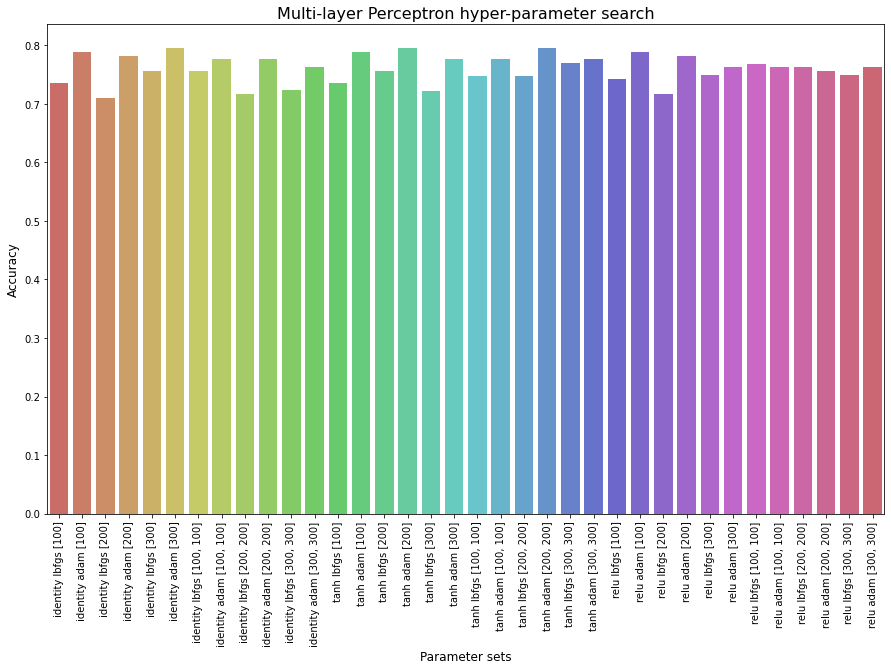

In [79]:
plt.figure(figsize=(15,9))
sns.barplot(data=result_plot, x='params', y='values', palette='hls')
plt.xticks(rotation=90)
plt.xlabel('Parameter sets', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Multi-layer Perceptron hyper-parameter search", fontsize=16)
plt.show()

For our dataset, the hyper-parameter set that gave the highest mean accuracy is as follows,

 - Activation function: tanh
 - Solver: adam
 - Hidden layer size(s): 200 x 2
 
Overall, the 'adam' solver appears to outperform the 'lbgfs' solver by a noticeable margin, however the difference is less prominent when using the 'relu' activation function with 2 hidden layers.

In [80]:
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=[200, 200], solver='adam', activation='tanh', max_iter=10000)
mlp.fit(train_X, train_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

In [81]:
print(accuracy_score(train_y, mlp.predict(train_X)))
print(accuracy_score(test_y, mlp.predict(test_X)))

0.9416666666666667
0.7096774193548387


In [82]:
mlp_result = pd.DataFrame(test['PartyNm'])
mlp_result.columns = ["Actual"]
mlp_result.insert(1, "Predicted", rf.predict(test_X))
mlp_result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(mlp_result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,LNP,LNP,59.85
Brand,ALP,ALP,56.66
Kennedy,Other,LNP,63.33
Jagajaga,ALP,LNP,56.57
Warringah,Other,LNP,57.24
Cook,LNP,LNP,69.02
Hunter,ALP,LNP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


### Model comparison

In [83]:
all_results = pd.DataFrame([
    gs_knn.best_score_,
    gs_dt.best_score_,
    gs_rf.best_score_,
    gs_mlp.best_score_,
], index=['KNN', 'Decision Tree', 'Random Forest', 'Multi-layer Perceptron'], columns=['Accuracy'])
all_results.index.name = "Model"
all_results

,Accuracy
Model,
KNN,0.749583
Decision Tree,0.737083
Random Forest,0.769583
Multi-layer Perceptron,0.795833


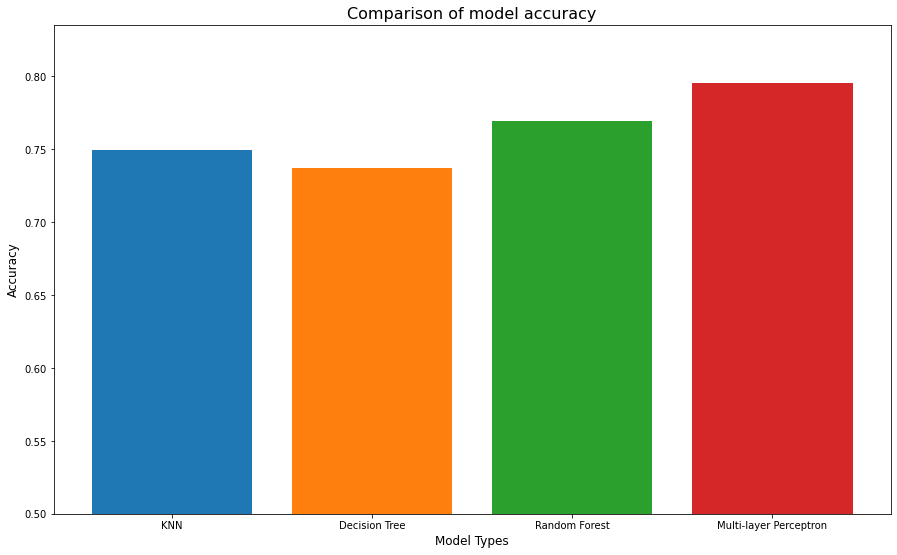

In [84]:
plt.figure(figsize=(15,9))
plt.bar(x=all_results.index, height=all_results['Accuracy'], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
plt.ylim(bottom=0.5)
plt.xlabel("Model Types", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Accuracy", fontsize=12)
plt.yticks(fontsize=10)
plt.title("Comparison of model accuracy", fontsize=16)
plt.show()

The Multi-layer Perecptron model produced the best mean accuracy of all non-regression models at 0.796 mean accuracy. This may be because the MLP model is able to capture more nuanced relationships in teh data compared to the other model types. Therefore, this model will be used for the final non-regression model going forward.

### Refining MLP model

While the overall accuracy of the MLP model above is reasonably good, there is a significant difference between the accuracy of the model using the training dataset compared to the  test dataset, indicating a high likelihood of the model overfitting. This may be due to the high number of features in used in training the model compared to the number of samples available.

Therefore, we used permutation analysis to determine the features that had the greatest impact on model accuracy to further refine the model. [Permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html), or "Mean Decrease Accuracy", works by randomising the data on a per feature basis and measuring the subsequent change in accuracy to determine the importance of that feature to the overall accuracy. To ensure that no errors are introduced by using actual random data (e.g. out of range errors), the values are randomly permuted between samples rather than being extracted from a random function.

In [85]:
perm_group = PermutationImportance(mlp, random_state=42, cv=KFold(n_splits=10, shuffle=True, random_state=42)).fit(test_X, test_y)

In [86]:
perm_result = pd.DataFrame(test_X.columns, columns=['label'])
perm_result.insert(1, "feature importance", perm_group.feature_importances_)
perm_result = perm_result.set_index('label')
perm_result.sort_values('feature importance', ascending=False)

,feature importance
label,
RELP - Christianity,0.080000
RLHP - Lone person,0.071667
"LFHRP - Employed, worked part-time",0.060000
GNGP - National Government,0.055000
LFHRP - Not applicable,0.053333
...,...
MDCP - Not married,-0.006667
GNGP - State/Territory Government,-0.006667
MDCP - Married in a registered marriage,-0.006667


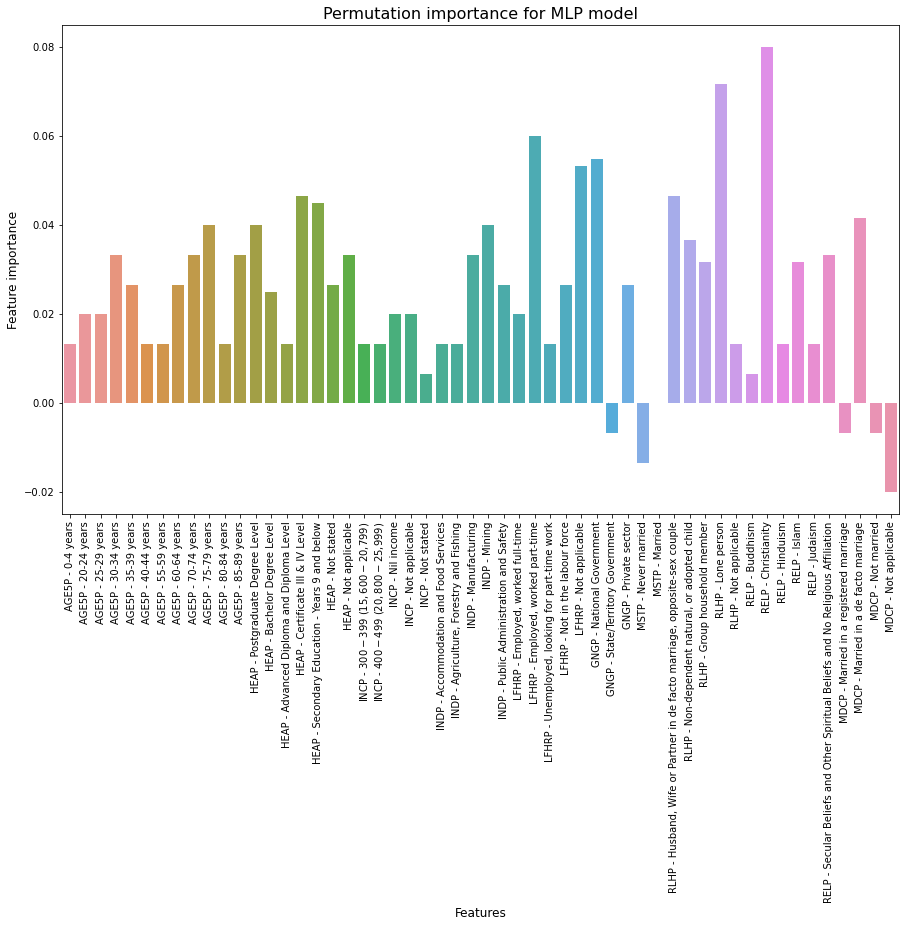

In [87]:
perm_result_no_zeroes = perm_result[perm_result['feature importance'] != 0]
perm_result_no_zeroes['code'] = perm_result_no_zeroes.reset_index()['label'].apply(lambda x: x[0:5])

plt.figure(figsize=(15,9))
sns.barplot(data=perm_result_no_zeroes, x=perm_result_no_zeroes.index, y='feature importance')
plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Feature importance', fontsize=12)
plt.title("Permutation importance for MLP model", fontsize=16)
plt.show()

Only 54 of the 138 available features had any impact on model accuracy when the data was permuted, suggesting that most features had a negligible effect, or no effect at all, on the models' predictive capacity.

Interestingly, there are 5 features that had a positive impact on model accuracy when they were permuted ('State/Territory Government', 'Never Married', 'Married in a registered marriage', 'Not married', 'Not Applicable' (in regards to marriage status)), indicating these features were having a negative effect on model accuracy when included.

In [88]:
perm_results_cutoff = pd.DataFrame(columns=['Cutoff', 'Train Acc', 'Test Acc'])

for i in np.arange(0, 0.08, 0.005):
    print('Cutoff:', i)
    group_train_small, group_test_small = train_test_split(all_df_norm_major_groups, test_size=0.1, random_state=42)
    group_train_small_X = group_train_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(perm_result['feature importance'] > i).values]
    group_train_small_y = group_train_small['PartyNm']
    group_test_small_X = group_test_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(perm_result['feature importance'] > i).values]
    group_test_small_y = group_test_small['PartyNm']
    
    mlp_group_small = MLPClassifier(random_state=42, hidden_layer_sizes=[200,200], solver='adam', activation='tanh', max_iter=10000)
    mlp_group_small.fit(group_train_small_X, group_train_small_y)
    
    print("Training accuracy:", accuracy_score(group_train_small_y, mlp_group_small.predict(group_train_small_X)))
    print("Test accuracy:", accuracy_score(group_test_small_y, mlp_group_small.predict(group_test_small_X)), '\n')
    
    perm_results_cutoff = perm_results_cutoff.append({'Cutoff': str(i),
                                                      'Train Acc': accuracy_score(group_train_small_y, mlp_group_small.predict(group_train_small_X)),
                                                      'Test Acc': accuracy_score(group_test_small_y, mlp_group_small.predict(group_test_small_X))}
                                                     , ignore_index=True)

Cutoff: 0.0
Training accuracy: 0.9185185185185185
Test accuracy: 0.6875 

Cutoff: 0.005
Training accuracy: 0.9185185185185185
Test accuracy: 0.6875 

Cutoff: 0.01
Training accuracy: 0.9111111111111111
Test accuracy: 0.75 

Cutoff: 0.015
Training accuracy: 0.8888888888888888
Test accuracy: 0.6875 

Cutoff: 0.02
Training accuracy: 0.8814814814814815
Test accuracy: 0.6875 

Cutoff: 0.025
Training accuracy: 0.8888888888888888
Test accuracy: 0.75 

Cutoff: 0.03
Training accuracy: 0.8518518518518519
Test accuracy: 0.6875 

Cutoff: 0.035
Training accuracy: 0.837037037037037
Test accuracy: 0.8125 

Cutoff: 0.04
Training accuracy: 0.7925925925925926
Test accuracy: 0.8125 

Cutoff: 0.045
Training accuracy: 0.6148148148148148
Test accuracy: 0.5625 

Cutoff: 0.05
Training accuracy: 0.6518518518518519
Test accuracy: 0.625 

Cutoff: 0.055
Training accuracy: 0.6148148148148148
Test accuracy: 0.4375 

Cutoff: 0.06
Training accuracy: 0.6666666666666666
Test accuracy: 0.5625 

Cutoff: 0.065
Training acc

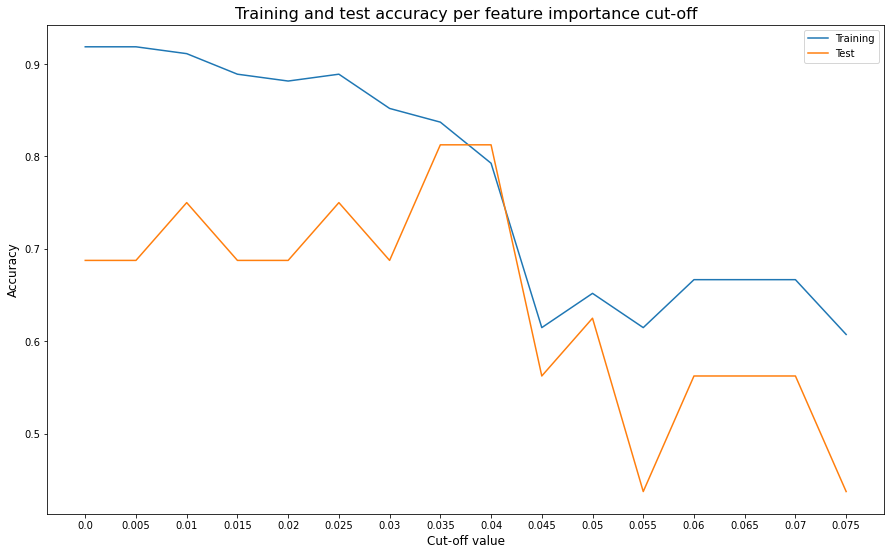

In [89]:
plt.figure(figsize=(15,9))
plt.plot(perm_results_cutoff['Cutoff'], perm_results_cutoff['Train Acc'], label='Training')
plt.plot(perm_results_cutoff['Cutoff'], perm_results_cutoff['Test Acc'], label='Test')
plt.legend()
plt.xlabel('Cut-off value', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Training and test accuracy per feature importance cut-off", fontsize=16)
plt.show()

Using a cut-off value of >0.035 feature importance gave the best overall accuracy whilst keeping overfitting to a minimum. Therefore, we can use features with permutation importance values greater than 0.035 to build and accurate model whilst significantly reducing the number of features required.

In [90]:
best_features = perm_result[perm_result['feature importance'] > 0.035]
best_features.sort_values('feature importance', ascending=False)

,feature importance
label,
RELP - Christianity,0.080000
RLHP - Lone person,0.071667
"LFHRP - Employed, worked part-time",0.060000
GNGP - National Government,0.055000
LFHRP - Not applicable,0.053333
HEAP - Certificate III & IV Level,0.046667
"RLHP - Husband, Wife or Partner in de facto marriage, opposite-sex couple",0.046667
HEAP - Secondary Education - Years 9 and below,0.045000
MDCP - Married in a de facto marriage,0.041667


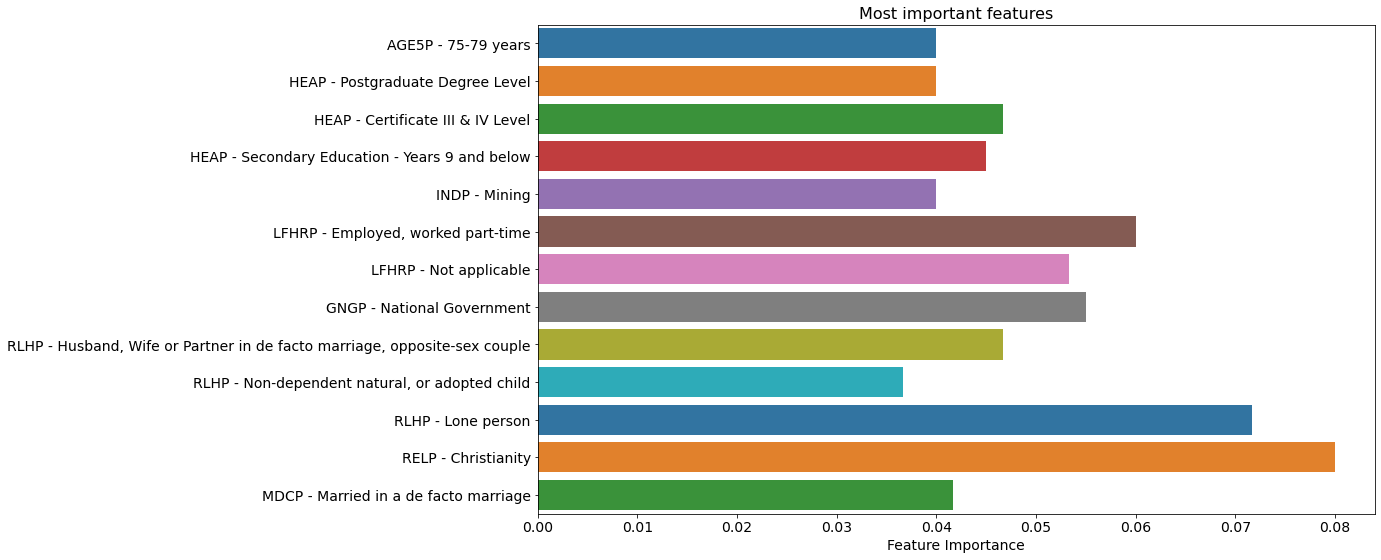

In [91]:
plt.figure(figsize=(15,9))
sns.barplot(data=best_features.reset_index(), y='label', x='feature importance', palette='tab10')
#plt.xticks(rotation=90)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Most important features", fontsize=16)
plt.show()

The feature 'Christianity' was the most important feature for the accuracy of the MLP model, with other factors such as marita/relationship status ('Lone person', 'Husband, Wife or Partner in de facto marriage, opposite sex couple', 'Married in de facto marriage'), education level ('Postgraduate Degree Level', 'Certificate III & IV', 'Secondary Education - Years 9 and below') and job/employment status ('Mining', 'National Government', 'Employed, worked part-time') being some of the most important.

In [92]:
group_train_small, group_test_small = train_test_split(all_df_norm_major_groups, test_size=0.1, random_state=42)
group_train_small_X = group_train_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(perm_result['feature importance'] > 0.035).values]
group_train_small_y = group_train_small['PartyNm']
group_test_small_X = group_test_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(perm_result['feature importance'] > 0.035).values]
group_test_small_y = group_test_small['PartyNm']

mlp_final = MLPClassifier(random_state=42, hidden_layer_sizes=[200,200], solver='adam', activation='tanh', max_iter=10000)
mlp_final.fit(group_train_small_X, group_train_small_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

In [93]:
print(accuracy_score(group_train_small_y, mlp_final.predict(group_train_small_X)))
print(accuracy_score(group_test_small_y, mlp_final.predict(group_test_small_X)))

0.837037037037037
0.8125


In [94]:
mlp_final_result = pd.DataFrame(y)
mlp_final_result.columns = ["Actual"]
mlp_final_result.insert(1, "Predicted", mlp_final.predict(X.loc[:,(perm_result['feature importance'] > 0.035).values]))
mlp_final_result.insert(2, "Pref Percent", all_df['PreferencePercent'].values)
display(mlp_final_result)

,Actual,Predicted,Pref Percent
LGA,,,
Adelaide,ALP,ALP,58.18
Aston,LNP,ALP,60.13
Ballarat,ALP,ALP,60.98
Banks,LNP,ALP,56.26
Barker,LNP,LNP,68.94
...,...,...,...
Werriwa,ALP,ALP,55.47
Whitlam,ALP,LNP,60.91
Wide Bay,LNP,LNP,63.15


In [95]:
print(accuracy_score(y,mlp_final.predict(X.loc[:,(perm_result['feature importance'] > 0.035).values])))

0.8344370860927153


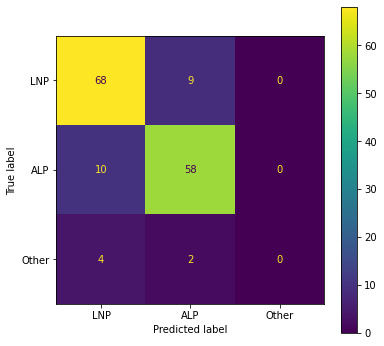

In [96]:
conf = ConfusionMatrixDisplay(confusion_matrix(mlp_final_result.iloc[:,0],mlp_final_result.iloc[:,1],
                                               labels=["LNP", "ALP", "Other"]), 
                              display_labels=["LNP", "ALP", "Other"]).plot()
conf.figure_.set_figheight(6)
plt.show()

The final MLP model correctly predicted the winning party in 126 out of 151 electorates with an accuracy of 83.44%. However it was unable to correctly predict the results in any of the electorates where a minor party or independent candidate won.

# Results and Insights

## Regression 

### 1) Major Party Model (Overall Accuracy 67%)

- 61% accurate at predicting if a seat is ALP
- 65% accurate at predicting if a seat is LNP
- 94% accurate at predicting if a seat is Other

#### Most Important demographic

The proportion of an electorate's population who identify as Christian is the most important in determining whether an electorate votes ALP or LNP, relatively high Christian electorates tend to vote LNP while relatively low Christian electorates tend to vote ALP.

#### Most important set of demographics

Across all three models in the Major party model, religion is the most impactful set of demographics, with Christianity, Islam & Secular beliefs being present in at least one if not all 3 models, and also having the largest coefficient in magnitude in all 3 models.

The next most impactful set of demographics is registered martial status, with high proportions of being married a LNP trait, while high proportions never being married an ALP trait.

#### Coefficients of is_ALP & is_LNP are inverses of each other

As would be expected for both is_ALP & is_LNP, with respect to their most impactful coefficients, the coefficients are inverses of each other. The proportion of people who are identify as Muslim (follow Islam) or who have never married are the strongest indicators that an electorate will vote for the Australian Labor Party (ALP)/ not vote for the Liberal National Coalition (LNP), while being the proportion of residents being married or Christian are the strongest indicators that an electorate will vote LNP/ not vote ALP.   

### 2) Seat type model

- 61% accurate at predicting a marginal seat
- 87% accurate at predicting a fairly safe ALP seat
- 84% accurate at predicting a fairly safe LNP seat
- 90% accurate at predicting a safe ALP seat
- 81% accurate at predicting a safe LNP seat
- 97% accurate at predicting an other seat

#### Most Important demographic

Like the major party model the proportion of an electorates population who identify as Christian is the most important factor, appearing in all models, positively affecting fairly safe LNP & safe LNP, while negatively affecting Marginal, fairly safe ALP & safe ALP seats.

#### Most important set of demographics

Across all models in the seat type model, religion is the most impactful set of demographics, with Christianity, Islam, Secular beliefs & Buddhism being present in at least one of of not all of the models, and also having the largest coefficient in magnitude in all models.

Marital status is the next most important set of demographics. Like the Major party model, not being married is associated with fairly safe/ safe ALP seats while being married associated with fairly safe/ safe LNP seats.

#### Differentiation of fairly safe vs. safe LNP seat

Both categories share coefficients, Christianity & being married a positive influence, not being married & Islam a negative influence, but the key demographic that separates these 2 seats is the highest education level achieved through a Bachelor's degree, a positive influence for fairly safe LNP whilst a negative influence for safe LNP seats.

## Non-regression

### 1) Model type evaluation

#### Mean accuracy
 - K-Nearest Neighbours: 74.96%
 - Decision Tree: 73.71%
 - Random Forest: 76.96%
 - Multi-layer Perceptron: 79.58%

The Multi-layer Perceptron model performed the best out of all non-regression model types at 79.58% mean accuracy, likely due to their structure allowing them to capture relationships between features that other model types cannot. As expected, the Random Forest model outperformed the Decision Tree model. Decision Tree models are known to be susceptible to overfitting, which may be why the Random Forest model, which is an ensemble of Decision Trees, outperformed it by over 3% on average.

### 2) Multi-layer Perceptron model

The Multi-layer Perceptron model built using 13 of the demographic factors identified as being most important for predicting voing outcomes produced a model that was 83.44% accurate at predicting the overall electoral outcomes per CED.

#### Most important demographic

Having the proportion of census respondents who self-identify as Christian was the most important factor for determining the accuracy of the MLP model. This agrees with the conclusions of the logistic regression models, indicating that this feature is very important regardless of model type. Note that this does not suggest that Christians are more likely to vote for a particular party, only that knowing the proportion of Christians in a particular electorate is important for building accurate models.

#### Most important set of demographics

The following features were identified as being most important for producing an accurate MLP model and hence were used in the final model.

 - AGE5P - 75-79 Years
 - HEAP - Postgraduate Degree Level
 - HEAP - Certificate III & IV Level
 - HEAP - Secondary Education - Years 9 and below
 - INDP - Mining
 - LFHRP - Employed, worked part-time
 - LFHRP - Not Applicable
 - GNGP - National Government
 - RLHP - Husband, Wife or Partner in de facto marriage, opposite sex couple
 - RLHP - Non-dependent natural, or adopted child
 - RLHP - Lone person
 - RELP - Christianity
 - MDCP - Married in a defacto marriage

Aside from religion, it appears that features relating to marital and relationship status are significant for building an accurate model, which again corresponds with the results of the logistic regression models. Additionally, features related to education level are important for MLP model accuracy, as well as the sector and industry that people reported working in. 

Interestingly, only one age group (75-79 years) was highly significant in determining the model accuracy. Also worth noting is that out of all demographic categories available, sex was the only category that was not relevant in any significant way for building an accurate MLP model.

# Caveats

## Regression 

### 1) The Other category

The is_Other & is_Other_strength categories in both models, whilst boasting an impressive 93.55 % & 97% accuracy on testing data, is misleading. This is because it could not predict any electorate to be a non-major party, even those that were. Essentially if we were to ask this model if a non-traditional party won a particular seat it would always reply no. The reasons for this are twofold:
1) The category doesn't have enough data points and hence can't train enough data to reliably predict that category.

2) The category contains data that are probably not similar in nature. For instance the category contains the Greens, a left-wing political party & The Katters' Australian party, a right-wing polictical party.

### 2) The Seat Type Model

This model whilst providing interesting insight and high accuracies suffers the same flaws as that of the other category. It appears further subdividing seats with the limited amount of data we have, means we can't train enough data for the model to accurately recognise that a seat is the category its meant to recognise. Most of the accuracy comes from the model selecting no as its response, even when the seat should be returning yes, this is for any particular category (is_Safe_ALP, is_Marginal). This is due to the lack representation coming from any one category and the relatively high amount of subdivision means 'no' is generally the correct response.   

## Multi-layer Perceptron

### 1) The Other category

All non-regression models built had significant difficulties correctly predicting election outcomes in cases where minor parties or independent candidates won. In almost all cases, the models couldn't predict these outcomes at all. In this way, the non-regression models suffer from the same issues as the logistic regression models in that grouping all minor parties and independents into a single category fails to capture the broad range of political positions that these parties and candidates can take. Future research may look at building models at a more granular level to determine if it is possible to predict non-major party victories.

### 2) Black-box estimation

The relative complexity of Multi-layer Perceptron models makes them ideal for fitting data with nuanced relationships between features, however this also makes it difficult to interpret such models and how it derives its predictions. By comparison, the coefficients of a logistic regression model can be analysed directly to determine which features are most important to the model. In our analysis, we used permutation importance to determine the most important features to the MLP model, however this only identifies features important to the overall model accuracy and cannot identify features important to specific classes. 

## Other caveats

### 1) Non-party factors

Our analysis only examines the relationship between the demographics of a particular electorate and the elected party and does not examine other factors that may affect voting decisions. For example, certain candidates may have more prominent public profiles as a result of media coverage or being on the political front-bench. Thus, voters may base their voting decisions more on the candidate rather than the party.

### 2) Sample size

There were only 151 electorates with both census data and voting data available, which is a relatively low sample count compared to the number of features available. It may be possible to derive more samples by examining federal elections from other years to develop more robust models.


### 3) Demographic changes over time

Our analysis assumes that there were no changes to the demographics of each electorate between 2016 and 2019 aside from the CED boundaries, howwever it is unlikely that the demographics of each remained static over this time period. It may be possible to identify trends in demography by examining other census years and thus build a model that accounts for change sin demography over time.